In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install shap
!pip install pytorch-tabnet
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 

In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc, precision_score, recall_score, accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

from sklearn.linear_model import Lasso

from tabpfn import TabPFNClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LogisticRegression

import shap
from sklearn.inspection import PartialDependenceDisplay

import pickle

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/TQP-atSDH/final_data.csv', index_col = 0)

In [5]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Discharge Disposition'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  111183
Number of patients after exclusion:  104055
Number of patients excluded with this criteria:  7128


In [6]:
#Define outcome of interest.

data.loc[data['Discharge Disposition'] == 'Discharged to home or self-care (routine discharge)', 'OUTCOME'] = 0
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to inpatient rehab or designated unit', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to home under care of organized home health service', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to a short-term general hospital for inpatient care', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 'OUTCOME'] = 1
data = data[data['OUTCOME'].notna()]

print(data['OUTCOME'].value_counts(normalize=False, dropna=False))
print(data['OUTCOME'].value_counts(normalize=True, dropna=False))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.0    46668
1.0    36320
Name: OUTCOME, dtype: int64
0.0    0.562346
1.0    0.437654
Name: OUTCOME, dtype: float64


In [7]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [8]:
#Check data shapes.

print(y.shape)
print(x.shape)

(82988,)
(82988, 77)


In [9]:
#Split data into initial train set and test set in 90:10 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  74689
Number patients y_train dataset:  74689
Number patients x_test dataset:  8299
Number patients y_test dataset:  8299


In [10]:
#Split initial train set into final train set and validation set in 60:30 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 1/3, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  49792
Number patients train_y dataset:  49792
Number patients valid_x dataset:  24897
Number patients valid_y dataset:  24897


In [11]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 21671
Before resampling, counts of label '0': 28121 



In [12]:
#Apply RUS.

from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [13]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 21671
After resampling, counts of label '0': 21671 



In [14]:
#Define function for AUROC with 95% confidence intervals.

def auroc_ci(y_test, y_probs, positive=1, n_samples=1000, alpha=0.05):
    auroc_values = []
    for i in range(n_samples):
        y_test_bs, y_probs_bs = resample(y_test, y_probs)
        
        auroc = roc_auc_score(y_test_bs, y_probs_bs)
        auroc_values.append(auroc)
    
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    lower_ci = mean_auroc - 1.96 * std_auroc
    upper_ci = mean_auroc + 1.96 * std_auroc
    
    return auroc, lower_ci, upper_ci

In [15]:
#Define z-value for other confidence intervals.

confidence = 0.95
z_value = st.norm.ppf((1 + confidence) / 2.0)

#Feature Selection

In [16]:
alpha = 0.025

lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
lasso.fit(train_x, train_y)

selected_features_idx = np.nonzero(lasso.coef_)[0]

selected_features = train_x.columns[selected_features_idx]
print("Selected features:", selected_features)

train_x = train_x[selected_features]
valid_x = valid_x[selected_features]
x_test = x_test[selected_features]

Selected features: Index(['Age', 'Weight', 'Systolic Blood Pressure', 'Pulse Rate',
       'Respiratory Rate', 'Total GCS', 'Bleeding Size', 'Mechanism of Injury',
       'Blood Transfusion', 'Primary Method of Payment'],
      dtype='object')


#TabPFN

No hyperparameter tuning is performed for TabPFN since the paper that introduced TabPFN claims no hyperparameter tuning is needed for it:


*We present TabPFN, a trained Transformer that can do supervised classification for small tabular datasets in less than a second, needs no hyperparameter tuning and is competitive with state-of-the-art classification methods.*

https://doi.org/10.48550/arXiv.2207.01848


In [17]:
#Fit TabPFN.

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=2)

tabpfn_data = data.sample(frac=0.10, random_state=42)
tabpfn_x = tabpfn_data.drop(outcomes, axis = 1)
tabpfn_x = tabpfn_x[selected_features]
tabpfn_y = tabpfn_data['OUTCOME']
tabpfn_x_train, tabpfn_x_test, tabpfn_y_train, tabpfn_y_test = train_test_split(tabpfn_x, tabpfn_y, test_size = 0.1, random_state = 0)
tabpfn_train_x, tabpfn_valid_x, tabpfn_train_y, tabpfn_valid_y = train_test_split(tabpfn_x_train, tabpfn_y_train, test_size = 1/3, random_state = 0)
tabpfn_train_x, tabpfn_train_y = resampler.fit_resample(tabpfn_train_x, tabpfn_train_y)

tabpfn.fit(tabpfn_train_x, tabpfn_train_y, overwrite_warning = True)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=2)

In [18]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabpfn = tabpfn.predict_proba(tabpfn_valid_x.values)

calib_model_tabpfn = LogisticRegression()
calib_model_tabpfn.fit(calib_probs_tabpfn, tabpfn_valid_y)

LogisticRegression()

In [19]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabpfn = tabpfn.predict(tabpfn_x_test.values)

uncalibrated_probs_tabpfn = tabpfn.predict_proba(tabpfn_x_test.values)

probs_tabpfn = calib_model_tabpfn.predict_proba(uncalibrated_probs_tabpfn)
probs_tabpfn = probs_tabpfn[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [62]:
#Evaluate TabNet model.

tabpfn_precision = round(precision_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_precision_ci_length = z_value * np.sqrt((tabpfn_precision * (1 - tabpfn_precision)) / y_test.shape[0])
tabpfn_precision_ci_lower = round((tabpfn_precision - tabpfn_precision_ci_length), 3)
tabpfn_precision_ci_upper = round((tabpfn_precision + tabpfn_precision_ci_length), 3)
tabpfn_precision_str = str(tabpfn_precision) + ' (' + str(tabpfn_precision_ci_lower) + ' - ' + str(tabpfn_precision_ci_upper) + ')'

tabpfn_recall = round(recall_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_recall_ci_length = z_value * np.sqrt((tabpfn_recall * (1 - tabpfn_recall)) / y_test.shape[0])
tabpfn_recall_ci_lower = round((tabpfn_recall - tabpfn_recall_ci_length), 3)
tabpfn_recall_ci_upper = round((tabpfn_recall + tabpfn_recall_ci_length), 3)
tabpfn_recall_str = str(tabpfn_recall) + ' (' + str(tabpfn_recall_ci_lower) + ' - ' + str(tabpfn_recall_ci_upper) + ')'

tabpfn_auprc = round(average_precision_score(tabpfn_y_test, probs_tabpfn, average = 'weighted'), 3)
tabpfn_auprc_ci_length = z_value * np.sqrt((tabpfn_auprc * (1 - tabpfn_auprc)) / y_test.shape[0])
tabpfn_auprc_ci_lower = round((tabpfn_auprc - tabpfn_auprc_ci_length), 3)
tabpfn_auprc_ci_upper = round((tabpfn_auprc + tabpfn_auprc_ci_length), 3)
tabpfn_auprc_str = str(tabpfn_auprc) + ' (' + str(tabpfn_auprc_ci_lower) + ' - ' + str(tabpfn_auprc_ci_upper) + ')'

tabpfn_accuracy = round(balanced_accuracy_score(tabpfn_y_test, preds_tabpfn), 3)
tabpfn_accuracy_ci_length = z_value * np.sqrt((tabpfn_accuracy * (1 - tabpfn_accuracy)) / y_test.shape[0])
tabpfn_accuracy_ci_lower = round((tabpfn_accuracy - tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_ci_upper = round((tabpfn_accuracy + tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_str = str(tabpfn_accuracy) + ' (' + str(tabpfn_accuracy_ci_lower) + ' - ' + str(tabpfn_accuracy_ci_upper) + ')'

tabpfn_auroc, tabpfn_auroc_ci_lower, tabpfn_auroc_ci_upper = auroc_ci(tabpfn_y_test, probs_tabpfn)
tabpfn_auroc = round(tabpfn_auroc, 3)
tabpfn_auroc_ci_lower = round(tabpfn_auroc_ci_lower, 3)
tabpfn_auroc_ci_upper = round(tabpfn_auroc_ci_upper, 3)
tabpfn_auroc_str = str(tabpfn_auroc) + ' (' + str(tabpfn_auroc_ci_lower) + ' - ' + str(tabpfn_auroc_ci_upper) + ')'

tabpfn_brier = round(brier_score_loss(tabpfn_y_test, probs_tabpfn), 3)
tabpfn_brier_ci_length = z_value * np.sqrt((tabpfn_brier * (1 - tabpfn_brier)) / y_test.shape[0])
tabpfn_brier_ci_lower = round((tabpfn_brier - tabpfn_brier_ci_length), 3)
tabpfn_brier_ci_upper = round((tabpfn_brier + tabpfn_brier_ci_length), 3)
tabpfn_brier_str = str(tabpfn_brier) + ' (' + str(tabpfn_brier_ci_lower) + ' - ' + str(tabpfn_brier_ci_upper) + ')'

tabpfn_results = [tabpfn_precision_str, tabpfn_recall_str, tabpfn_auprc_str, tabpfn_accuracy_str, tabpfn_auroc_str, tabpfn_brier_str]

print("Precision: ", (tabpfn_precision_str))
print("Recall: ", (tabpfn_recall_str))
print('AUPRC: ', (tabpfn_auprc_str))
print('Accuracy: ', (tabpfn_accuracy_str))
print('AUROC: ', (tabpfn_auroc_str))
print('Brier Score: ', (tabpfn_brier_str))

Precision:  0.697 (0.687 - 0.707)
Recall:  0.686 (0.676 - 0.696)
AUPRC:  0.713 (0.703 - 0.723)
Accuracy:  0.691 (0.681 - 0.701)
AUROC:  0.741 (0.731 - 0.796)
Brier Score:  0.197 (0.188 - 0.206)


In [68]:
#Recalculate precision recall curve for plotting purposes.

tabpfn_precision_curve, tabpfn_recall_curve, _ = precision_recall_curve(tabpfn_y_test, probs_tabpfn)

# TabNet

In [22]:
# Hyperparameter tuning for TabNet.

def objective(trial):

    param = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 1, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "n_independent": trial.suggest_int("n_independent", 1, 5),
        "n_shared": trial.suggest_int("n_shared", 1, 5),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-6, 1e-3),
        "optimizer_params": {"lr": trial.suggest_loguniform("lr", 1e-5, 1e-2)},
        "seed": 31,
    }

    tabnet_clf = TabNetClassifier(**param)

    tabnet_clf.fit(
        train_x.values,
        train_y.values,
        eval_set=[(valid_x.values, valid_y.values)],
        eval_metric=["auc"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    preds = tabnet_clf.predict_proba(valid_x.values)[:, 1]
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    tabnet_params = {}

    for key, value in trial.params.items():
        tabnet_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:29:47,435] A new study created in memory with name: no-name-599e906f-4752-4edb-a166-9cfb8c19aecf
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 1.29696 | val_0_auc: 0.46501 |  0:00:11s
epoch 1  | loss: 1.29599 | val_0_auc: 0.46743 |  0:00:21s
epoch 2  | loss: 1.26091 | val_0_auc: 0.54599 |  0:00:31s
epoch 3  | loss: 1.2342  | val_0_auc: 0.55853 |  0:00:42s
epoch 4  | loss: 1.22201 | val_0_auc: 0.55757 |  0:00:51s
epoch 5  | loss: 1.20422 | val_0_auc: 0.54034 |  0:01:02s
epoch 6  | loss: 1.20039 | val_0_auc: 0.52992 |  0:01:13s
epoch 7  | loss: 1.18365 | val_0_auc: 0.51711 |  0:01:22s
epoch 8  | loss: 1.1748  | val_0_auc: 0.50371 |  0:01:33s
epoch 9  | loss: 1.15692 | val_0_auc: 0.5004  |  0:01:44s
epoch 10 | loss: 1.14467 | val_0_auc: 0.50149 |  0:01:54s
epoch 11 | loss: 1.123   | val_0_auc: 0.5027  |  0:02:05s
epoch 12 | loss: 1.12039 | val_0_auc: 0.50379 |  0:02:16s
epoch 13 | loss: 1.109   | val_0_auc: 0.50953 |  0:02:28s
epoch 14 | loss: 1.10505 | val_0_auc: 0.50373 |  0:02:38s
epoch 15 | loss: 1.08722 | val_0_auc: 0.50752 |  0:02:48s
epoch 16 | loss: 1.07102 | val_0_auc: 0.51895 |  0:02:59s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:34:05,283] Trial 0 finished with value: 0.5330592471669242 and parameters: {'n_d': 24, 'n_a': 62, 'n_steps': 8, 'gamma': 1.9868700030924629, 'n_independent': 2, 'n_shared': 1, 'lambda_sparse': 0.0005310328735364063, 'lr': 1.6066288228880885e-05}. Best is trial 0 with value: 0.5330592471669242.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.74519 | val_0_auc: 0.51091 |  0:00:03s
epoch 1  | loss: 0.72806 | val_0_auc: 0.52361 |  0:00:06s
epoch 2  | loss: 0.71476 | val_0_auc: 0.521   |  0:00:09s
epoch 3  | loss: 0.70592 | val_0_auc: 0.5226  |  0:00:13s
epoch 4  | loss: 0.69801 | val_0_auc: 0.53306 |  0:00:17s
epoch 5  | loss: 0.69198 | val_0_auc: 0.55164 |  0:00:20s
epoch 6  | loss: 0.68915 | val_0_auc: 0.56966 |  0:00:23s
epoch 7  | loss: 0.68743 | val_0_auc: 0.5875  |  0:00:26s
epoch 8  | loss: 0.68185 | val_0_auc: 0.59711 |  0:00:31s
epoch 9  | loss: 0.68016 | val_0_auc: 0.60267 |  0:00:35s
epoch 10 | loss: 0.67806 | val_0_auc: 0.61143 |  0:00:38s
epoch 11 | loss: 0.67582 | val_0_auc: 0.61987 |  0:00:41s
epoch 12 | loss: 0.67427 | val_0_auc: 0.62486 |  0:00:44s
epoch 13 | loss: 0.67339 | val_0_auc: 0.62688 |  0:00:49s
epoch 14 | loss: 0.67105 | val_0_auc: 0.63289 |  0:00:52s
epoch 15 | loss: 0.66964 | val_0_auc: 0.63527 |  0:00:55s
epoch 16 | loss: 0.66702 | val_0_auc: 0.64029 |  0:00:58s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:46:20,559] Trial 1 finished with value: 0.6846488087040623 and parameters: {'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06, 'lr': 3.826995629452713e-05}. Best is trial 1 with value: 0.6846488087040623.


Number of finished trials: 2
Best trial:
  Value: 0.6846488087040623
  Params: 
    n_d: 12
    n_a: 38
    n_steps: 1
    gamma: 1.3823932675263133
    n_independent: 4
    n_shared: 3
    lambda_sparse: 1.354780454607063e-06
    lr: 3.826995629452713e-05


In [23]:
#See TabNet hyperparameters.

tabnet_params.pop('lr')

print(tabnet_params)

{'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [24]:
#Fit TabNet.

tabnet = TabNetClassifier(**tabnet_params)

tabnet.fit(train_x.values, train_y.values)

Device used : cpu
No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 0.62736 |  0:00:02s
epoch 1  | loss: 0.59857 |  0:00:05s
epoch 2  | loss: 0.59236 |  0:00:08s
epoch 3  | loss: 0.58877 |  0:00:12s
epoch 4  | loss: 0.58459 |  0:00:14s
epoch 5  | loss: 0.58292 |  0:00:17s
epoch 6  | loss: 0.58337 |  0:00:19s
epoch 7  | loss: 0.58127 |  0:00:22s
epoch 8  | loss: 0.58037 |  0:00:25s
epoch 9  | loss: 0.57938 |  0:00:29s
epoch 10 | loss: 0.57873 |  0:00:31s
epoch 11 | loss: 0.57903 |  0:00:34s
epoch 12 | loss: 0.57845 |  0:00:36s
epoch 13 | loss: 0.57862 |  0:00:39s
epoch 14 | loss: 0.57806 |  0:00:42s
epoch 15 | loss: 0.57712 |  0:00:45s
epoch 16 | loss: 0.57771 |  0:00:48s
epoch 17 | loss: 0.5763  |  0:00:50s
epoch 18 | loss: 0.57546 |  0:00:53s
epoch 19 | loss: 0.57467 |  0:00:56s
epoch 20 | loss: 0.57719 |  0:00:59s
epoch 21 | loss: 0.5759  |  0:01:02s
epoch 22 | loss: 0.57653 |  0:01:05s
epoch 23 | loss: 0.57478 |  0:01:07s
epoch 24 | loss: 0.57541 |  0:01:10s
epoch 25 | loss: 0.57369 |  0:01:13s
epoch 26 | loss: 0.57375 |  0:01:17s
e

In [25]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabnet = tabnet.predict_proba(valid_x.values)

calib_model_tabnet = LogisticRegression()
calib_model_tabnet.fit(calib_probs_tabnet, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [26]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabnet = tabnet.predict(x_test.values)

uncalibrated_probs_tabnet = tabnet.predict_proba(x_test.values)

probs_tabnet = calib_model_tabnet.predict_proba(uncalibrated_probs_tabnet)
probs_tabnet = probs_tabnet[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [27]:
#Evaluate TabNet model.

tabnet_precision = round(precision_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_precision_ci_length = z_value * np.sqrt((tabnet_precision * (1 - tabnet_precision)) / y_test.shape[0])
tabnet_precision_ci_lower = round((tabnet_precision - tabnet_precision_ci_length), 3)
tabnet_precision_ci_upper = round((tabnet_precision + tabnet_precision_ci_length), 3)
tabnet_precision_str = str(tabnet_precision) + ' (' + str(tabnet_precision_ci_lower) + ' - ' + str(tabnet_precision_ci_upper) + ')'

tabnet_recall = round(recall_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_recall_ci_length = z_value * np.sqrt((tabnet_recall * (1 - tabnet_recall)) / y_test.shape[0])
tabnet_recall_ci_lower = round((tabnet_recall - tabnet_recall_ci_length), 3)
tabnet_recall_ci_upper = round((tabnet_recall + tabnet_recall_ci_length), 3)
tabnet_recall_str = str(tabnet_recall) + ' (' + str(tabnet_recall_ci_lower) + ' - ' + str(tabnet_recall_ci_upper) + ')'

tabnet_auprc = round(average_precision_score(y_test, probs_tabnet, average = 'weighted'), 3)
tabnet_auprc_ci_length = z_value * np.sqrt((tabnet_auprc * (1 - tabnet_auprc)) / y_test.shape[0])
tabnet_auprc_ci_lower = round((tabnet_auprc - tabnet_auprc_ci_length), 3)
tabnet_auprc_ci_upper = round((tabnet_auprc + tabnet_auprc_ci_length), 3)
tabnet_auprc_str = str(tabnet_auprc) + ' (' + str(tabnet_auprc_ci_lower) + ' - ' + str(tabnet_auprc_ci_upper) + ')'

tabnet_accuracy = round(balanced_accuracy_score(y_test, preds_tabnet), 3)
tabnet_accuracy_ci_length = z_value * np.sqrt((tabnet_accuracy * (1 - tabnet_accuracy)) / y_test.shape[0])
tabnet_accuracy_ci_lower = round((tabnet_accuracy - tabnet_accuracy_ci_length), 3)
tabnet_accuracy_ci_upper = round((tabnet_accuracy + tabnet_accuracy_ci_length), 3)
tabnet_accuracy_str = str(tabnet_accuracy) + ' (' + str(tabnet_accuracy_ci_lower) + ' - ' + str(tabnet_accuracy_ci_upper) + ')'

tabnet_auroc, tabnet_auroc_ci_lower, tabnet_auroc_ci_upper = auroc_ci(y_test, probs_tabnet)
tabnet_auroc = round(tabnet_auroc, 3)
tabnet_auroc_ci_lower = round(tabnet_auroc_ci_lower, 3)
tabnet_auroc_ci_upper = round(tabnet_auroc_ci_upper, 3)
tabnet_auroc_str = str(tabnet_auroc) + ' (' + str(tabnet_auroc_ci_lower) + ' - ' + str(tabnet_auroc_ci_upper) + ')'

tabnet_brier = round(brier_score_loss(y_test, probs_tabnet), 3)
tabnet_brier_ci_length = z_value * np.sqrt((tabnet_brier * (1 - tabnet_brier)) / y_test.shape[0])
tabnet_brier_ci_lower = round((tabnet_brier - tabnet_brier_ci_length), 3)
tabnet_brier_ci_upper = round((tabnet_brier + tabnet_brier_ci_length), 3)
tabnet_brier_str = str(tabnet_brier) + ' (' + str(tabnet_brier_ci_lower) + ' - ' + str(tabnet_brier_ci_upper) + ')'

tabnet_results = [tabnet_precision_str, tabnet_recall_str, tabnet_auprc_str, tabnet_accuracy_str, tabnet_auroc_str, tabnet_brier_str]

print("Precision: ", (tabnet_precision_str))
print("Recall: ", (tabnet_recall_str))
print('AUPRC: ', (tabnet_auprc_str))
print('Accuracy: ', (tabnet_accuracy_str))
print('AUROC: ', (tabnet_auroc_str))
print('Brier Score: ', (tabnet_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.69 (0.68 - 0.7)
Recall:  0.673 (0.663 - 0.683)
AUPRC:  0.649 (0.639 - 0.659)
Accuracy:  0.682 (0.672 - 0.692)
AUROC:  0.729 (0.725 - 0.746)
Brier Score:  0.206 (0.197 - 0.215)


In [28]:
#Recalculate precision recall curve for plotting purposes.

tabnet_precision_curve, tabnet_recall_curve, _ = precision_recall_curve(y_test, probs_tabnet)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# XGBoost

In [29]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:51:14,110] A new study created in memory with name: no-name-ead6da5b-6943-48e0-b9a4-4220d61538ed


[0]	validation-auc:0.74369


APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


[1]	validation-auc:0.74949
[2]	validation-auc:0.75126
[3]	validation-auc:0.75208
[4]	validation-auc:0.75163
[5]	validation-auc:0.75120
[6]	validation-auc:0.74952
[7]	validation-auc:0.74887
[8]	validation-auc:0.74799
[9]	validation-auc:0.74714


[I 2023-05-19 13:51:14,788] Trial 0 finished with value: 0.6850352679799823 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6850352679799823.


[0]	validation-auc:0.50153
[1]	validation-auc:0.57796
[2]	validation-auc:0.69947
[3]	validation-auc:0.71633
[4]	validation-auc:0.72389
[5]	validation-auc:0.72859
[6]	validation-auc:0.72956
[7]	validation-auc:0.73031
[8]	validation-auc:0.73554
[9]	validation-auc:0.73629


[I 2023-05-19 13:51:15,225] Trial 1 finished with value: 0.6669195415054613 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6850352679799823.


[0]	validation-auc:0.50000
[1]	validation-auc:0.51573
[2]	validation-auc:0.57273
[3]	validation-auc:0.65833
[4]	validation-auc:0.69947
[5]	validation-auc:0.71306
[6]	validation-auc:0.71766
[7]	validation-auc:0.72065
[8]	validation-auc:0.72507
[9]	validation-auc:0.72859


[I 2023-05-19 13:51:15,685] Trial 2 finished with value: 0.6669195415054613 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6850352679799823.


[0]	validation-auc:0.74265
[1]	validation-auc:0.74284
[2]	validation-auc:0.74288
[3]	validation-auc:0.74293
[4]	validation-auc:0.74289
[5]	validation-auc:0.74297
[6]	validation-auc:0.74309
[7]	validation-auc:0.74312
[8]	validation-auc:0.74315
[9]	validation-auc:0.74314


[I 2023-05-19 13:51:16,490] Trial 3 finished with value: 0.6803226148094769 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6850352679799823.


[0]	validation-auc:0.74410
[1]	validation-auc:0.74426
[2]	validation-auc:0.74423
[3]	validation-auc:0.74428
[4]	validation-auc:0.74425
[5]	validation-auc:0.74423
[6]	validation-auc:0.74421
[7]	validation-auc:0.74423
[8]	validation-auc:0.74421
[9]	validation-auc:0.74423


[I 2023-05-19 13:51:17,148] Trial 4 finished with value: 0.6827597085854571 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6850352679799823.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.65203
[4]	validation-auc:0.65203
[5]	validation-auc:0.65203


[I 2023-05-19 13:51:17,275] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74241
[2]	validation-auc:0.74353
[3]	validation-auc:0.74516
[4]	validation-auc:0.74668
[5]	validation-auc:0.74794
[6]	validation-auc:0.74925
[7]	validation-auc:0.74995
[8]	validation-auc:0.75065
[9]	validation-auc:0.75122


[I 2023-05-19 13:51:17,736] Trial 6 finished with value: 0.6864635916190929 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6864635916190929.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000


[I 2023-05-19 13:51:17,922] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74419
[1]	validation-auc:0.74430
[2]	validation-auc:0.74416
[3]	validation-auc:0.74427
[4]	validation-auc:0.74426
[5]	validation-auc:0.74428
[6]	validation-auc:0.74425
[7]	validation-auc:0.74423
[8]	validation-auc:0.74421
[9]	validation-auc:0.74423


[I 2023-05-19 13:51:18,628] Trial 8 finished with value: 0.6827597085854571 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.012396727001275e-07, 'alpha': 4.813416353568083e-07, 'max_depth': 7, 'eta': 7.282914217164152e-06, 'gamma': 1.2485590633659993e-05, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6864635916190929.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73202
[2]	validation-auc:0.73202
[3]	validation-auc:0.73202
[4]	validation-auc:0.73202


[I 2023-05-19 13:51:18,857] Trial 9 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69691
[1]	validation-auc:0.71899
[2]	validation-auc:0.72725
[3]	validation-auc:0.73796
[4]	validation-auc:0.74215


[I 2023-05-19 13:51:19,044] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73792
[1]	validation-auc:0.74633
[2]	validation-auc:0.74937
[3]	validation-auc:0.75195
[4]	validation-auc:0.75246
[5]	validation-auc:0.75290
[6]	validation-auc:0.75293
[7]	validation-auc:0.75225
[8]	validation-auc:0.75183
[9]	validation-auc:0.75147


[I 2023-05-19 13:51:19,905] Trial 11 finished with value: 0.6879121782315427 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.409109165337129e-05, 'alpha': 0.5044407594011535, 'max_depth': 9, 'eta': 0.38585538428714167, 'gamma': 1.2024518784549119e-08, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6879121782315427.


[0]	validation-auc:0.73712
[1]	validation-auc:0.74109
[2]	validation-auc:0.74395
[3]	validation-auc:0.74456
[4]	validation-auc:0.74631
[5]	validation-auc:0.74709
[6]	validation-auc:0.74831
[7]	validation-auc:0.74881
[8]	validation-auc:0.74941
[9]	validation-auc:0.75039


[I 2023-05-19 13:51:21,110] Trial 12 finished with value: 0.6864121193471853 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00044075660361127153, 'alpha': 0.2697778512538622, 'max_depth': 9, 'eta': 0.04181182025225589, 'gamma': 2.0368476286273254e-08, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6879121782315427.


[0]	validation-auc:0.74413
[1]	validation-auc:0.74445
[2]	validation-auc:0.74489
[3]	validation-auc:0.74520
[4]	validation-auc:0.74524
[5]	validation-auc:0.74549
[6]	validation-auc:0.74582
[7]	validation-auc:0.74621
[8]	validation-auc:0.74647
[9]	validation-auc:0.74653


[I 2023-05-19 13:51:21,983] Trial 13 finished with value: 0.6815072919019145 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5059844209148782, 'alpha': 0.027090345162628097, 'max_depth': 6, 'eta': 0.018734195550212166, 'gamma': 1.1747850775882438e-08, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6879121782315427.


[0]	validation-auc:0.73761
[1]	validation-auc:0.73879
[2]	validation-auc:0.74032
[3]	validation-auc:0.74037
[4]	validation-auc:0.74138


[I 2023-05-19 13:51:22,878] Trial 14 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73252
[1]	validation-auc:0.73810
[2]	validation-auc:0.74208
[3]	validation-auc:0.74348
[4]	validation-auc:0.74416
[5]	validation-auc:0.74513
[6]	validation-auc:0.74664
[7]	validation-auc:0.74754
[8]	validation-auc:0.74851
[9]	validation-auc:0.75009


[I 2023-05-19 13:51:23,553] Trial 15 finished with value: 0.6873393958107559 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0018202179249754964, 'alpha': 0.9476313496148697, 'max_depth': 4, 'eta': 0.11340754620992136, 'gamma': 1.4693431144583328e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6879121782315427.


[0]	validation-auc:0.72235
[1]	validation-auc:0.72235
[2]	validation-auc:0.72235
[3]	validation-auc:0.72259
[4]	validation-auc:0.72259
[5]	validation-auc:0.72259


[I 2023-05-19 13:51:23,902] Trial 16 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74456
[2]	validation-auc:0.74996
[3]	validation-auc:0.75269
[4]	validation-auc:0.75340
[5]	validation-auc:0.75605
[6]	validation-auc:0.75619
[7]	validation-auc:0.75634
[8]	validation-auc:0.75654
[9]	validation-auc:0.75614


[I 2023-05-19 13:51:24,524] Trial 17 finished with value: 0.6889474355302676 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.6456969106024798e-05, 'alpha': 0.11526493784407466, 'max_depth': 4, 'eta': 0.9416272290601821, 'gamma': 6.918904455894565e-08, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.6889474355302676.


[0]	validation-auc:0.74413
[1]	validation-auc:0.75164
[2]	validation-auc:0.75523
[3]	validation-auc:0.75675
[4]	validation-auc:0.75755
[5]	validation-auc:0.75752
[6]	validation-auc:0.75754
[7]	validation-auc:0.75692
[8]	validation-auc:0.75642
[9]	validation-auc:0.75569


[I 2023-05-19 13:51:25,431] Trial 18 finished with value: 0.6901793634418341 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.5169908270791636e-05, 'alpha': 0.10816643485647406, 'max_depth': 6, 'eta': 0.6996272912413347, 'gamma': 1.015230320060057e-08, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6901793634418341.


[0]	validation-auc:0.74399
[1]	validation-auc:0.74403
[2]	validation-auc:0.74458
[3]	validation-auc:0.74447
[4]	validation-auc:0.74465


[I 2023-05-19 13:51:26,010] Trial 19 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74300
[2]	validation-auc:0.74867
[3]	validation-auc:0.75261
[4]	validation-auc:0.75496
[5]	validation-auc:0.75728
[6]	validation-auc:0.75808
[7]	validation-auc:0.75898
[8]	validation-auc:0.75978
[9]	validation-auc:0.76001


[I 2023-05-19 13:51:26,689] Trial 20 finished with value: 0.6921595880364735 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.931743110130133e-06, 'alpha': 0.045377661272282696, 'max_depth': 4, 'eta': 0.46576196007417076, 'gamma': 1.99608170843794e-08, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.6921595880364735.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74304
[2]	validation-auc:0.74762
[3]	validation-auc:0.75234
[4]	validation-auc:0.75524
[5]	validation-auc:0.75607
[6]	validation-auc:0.75749
[7]	validation-auc:0.75959
[8]	validation-auc:0.76017
[9]	validation-auc:0.76045


[I 2023-05-19 13:51:27,161] Trial 21 finished with value: 0.6921732046760188 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.20110749547955e-06, 'alpha': 0.05466482701523296, 'max_depth': 4, 'eta': 0.43006340926758657, 'gamma': 1.2220900371553962e-08, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6921732046760188.


[0]	validation-auc:0.72235
[1]	validation-auc:0.72547
[2]	validation-auc:0.73411
[3]	validation-auc:0.73776
[4]	validation-auc:0.74279
[5]	validation-auc:0.74284


[I 2023-05-19 13:51:27,389] Trial 22 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74399
[1]	validation-auc:0.74973
[2]	validation-auc:0.75298
[3]	validation-auc:0.75389
[4]	validation-auc:0.75256
[5]	validation-auc:0.75212
[6]	validation-auc:0.75227
[7]	validation-auc:0.75156
[8]	validation-auc:0.75086
[9]	validation-auc:0.75094


[I 2023-05-19 13:51:27,937] Trial 23 finished with value: 0.688591007473071 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.56902863048076e-06, 'alpha': 0.06119844680479369, 'max_depth': 6, 'eta': 0.9403225371723434, 'gamma': 5.161893189217231e-07, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6921732046760188.


[0]	validation-auc:0.69691
[1]	validation-auc:0.69834
[2]	validation-auc:0.71343
[3]	validation-auc:0.71414
[4]	validation-auc:0.71666
[5]	validation-auc:0.71862


[I 2023-05-19 13:51:28,126] Trial 24 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73807
[2]	validation-auc:0.74285
[3]	validation-auc:0.74429
[4]	validation-auc:0.74587


[I 2023-05-19 13:51:28,381] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74399
[1]	validation-auc:0.74465
[2]	validation-auc:0.74500
[3]	validation-auc:0.74534
[4]	validation-auc:0.74568
[5]	validation-auc:0.74632


[I 2023-05-19 13:51:28,765] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69691
[1]	validation-auc:0.71663
[2]	validation-auc:0.72176
[3]	validation-auc:0.72700
[4]	validation-auc:0.73754


[I 2023-05-19 13:51:28,957] Trial 27 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.73977
[2]	validation-auc:0.74067
[3]	validation-auc:0.74100
[4]	validation-auc:0.74165


[I 2023-05-19 13:51:29,276] Trial 28 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72235
[1]	validation-auc:0.74103
[2]	validation-auc:0.74665
[3]	validation-auc:0.74983
[4]	validation-auc:0.75264
[5]	validation-auc:0.75437
[6]	validation-auc:0.75598
[7]	validation-auc:0.75681
[8]	validation-auc:0.75717
[9]	validation-auc:0.75739


[I 2023-05-19 13:51:29,621] Trial 29 finished with value: 0.6889366757343471 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.964158824679487e-06, 'alpha': 0.01633992683042592, 'max_depth': 3, 'eta': 0.8366389273494055, 'gamma': 3.6605476676091506e-07, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6921732046760188.


[0]	validation-auc:0.74219
[1]	validation-auc:0.74656
[2]	validation-auc:0.74849
[3]	validation-auc:0.75073
[4]	validation-auc:0.75143
[5]	validation-auc:0.75294
[6]	validation-auc:0.75356
[7]	validation-auc:0.75406
[8]	validation-auc:0.75449
[9]	validation-auc:0.75492


[I 2023-05-19 13:51:30,405] Trial 30 finished with value: 0.6899781474042561 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.66352783020742e-05, 'alpha': 0.21624150564180114, 'max_depth': 8, 'eta': 0.0814425366360411, 'gamma': 1.7316097294372893e-07, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6921732046760188.


[0]	validation-auc:0.74244
[1]	validation-auc:0.74828
[2]	validation-auc:0.75163
[3]	validation-auc:0.75283
[4]	validation-auc:0.75425
[5]	validation-auc:0.75502
[6]	validation-auc:0.75537
[7]	validation-auc:0.75528
[8]	validation-auc:0.75558
[9]	validation-auc:0.75555


[I 2023-05-19 13:51:31,204] Trial 31 finished with value: 0.6898118712514236 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.4772948008545084e-05, 'alpha': 0.25354476768732753, 'max_depth': 8, 'eta': 0.3183503003880086, 'gamma': 3.846597918346887e-08, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6921732046760188.


[0]	validation-auc:0.74257
[1]	validation-auc:0.74411
[2]	validation-auc:0.74249
[3]	validation-auc:0.74009
[4]	validation-auc:0.73943


[I 2023-05-19 13:51:31,647] Trial 32 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74361
[1]	validation-auc:0.74834
[2]	validation-auc:0.74957
[3]	validation-auc:0.75075
[4]	validation-auc:0.75145
[5]	validation-auc:0.75282
[6]	validation-auc:0.75373
[7]	validation-auc:0.75403
[8]	validation-auc:0.75478
[9]	validation-auc:0.75510


[I 2023-05-19 13:51:32,337] Trial 33 finished with value: 0.6895203357590389 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.812144240135673e-07, 'alpha': 0.1801660552453778, 'max_depth': 7, 'eta': 0.07895625034878957, 'gamma': 7.352558922287306e-07, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6921732046760188.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74747
[2]	validation-auc:0.75021
[3]	validation-auc:0.75194
[4]	validation-auc:0.75484
[5]	validation-auc:0.75648
[6]	validation-auc:0.75791
[7]	validation-auc:0.75970
[8]	validation-auc:0.76095
[9]	validation-auc:0.76143


[I 2023-05-19 13:51:32,853] Trial 34 finished with value: 0.693741788538045 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.815066538700225e-05, 'alpha': 0.005513925831117181, 'max_depth': 5, 'eta': 0.32163518988306045, 'gamma': 1.313032024161986e-07, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.693741788538045.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74628
[2]	validation-auc:0.74866
[3]	validation-auc:0.75121
[4]	validation-auc:0.75275
[5]	validation-auc:0.75483
[6]	validation-auc:0.75592
[7]	validation-auc:0.75748
[8]	validation-auc:0.75867
[9]	validation-auc:0.75944


[I 2023-05-19 13:51:33,369] Trial 35 finished with value: 0.6904081759997883 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0001636791008287977, 'alpha': 0.0053691765899132335, 'max_depth': 5, 'eta': 0.28191435235565016, 'gamma': 3.233635944127826e-08, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.693741788538045.


[0]	validation-auc:0.73954
[1]	validation-auc:0.73954
[2]	validation-auc:0.73954
[3]	validation-auc:0.73954
[4]	validation-auc:0.73954


[I 2023-05-19 13:51:33,677] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74084
[2]	validation-auc:0.74168
[3]	validation-auc:0.74375
[4]	validation-auc:0.74400


[I 2023-05-19 13:51:33,996] Trial 37 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73767
[2]	validation-auc:0.74330
[3]	validation-auc:0.74552
[4]	validation-auc:0.74798
[5]	validation-auc:0.75034


[I 2023-05-19 13:51:34,255] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.73993
[2]	validation-auc:0.74165
[3]	validation-auc:0.74100
[4]	validation-auc:0.74170
[5]	validation-auc:0.74359


[I 2023-05-19 13:51:34,563] Trial 39 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73807
[2]	validation-auc:0.74208
[3]	validation-auc:0.74348
[4]	validation-auc:0.74412
[5]	validation-auc:0.74534


[I 2023-05-19 13:51:34,850] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74399
[1]	validation-auc:0.74853
[2]	validation-auc:0.75167
[3]	validation-auc:0.75432
[4]	validation-auc:0.75546
[5]	validation-auc:0.75736
[6]	validation-auc:0.75854
[7]	validation-auc:0.75904
[8]	validation-auc:0.75924
[9]	validation-auc:0.75964


[I 2023-05-19 13:51:35,459] Trial 41 finished with value: 0.693605877393225 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.417312558436581e-06, 'alpha': 0.036059270317027194, 'max_depth': 6, 'eta': 0.273920457163518, 'gamma': 3.317055147480881e-08, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.693741788538045.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74747
[2]	validation-auc:0.75021
[3]	validation-auc:0.75187
[4]	validation-auc:0.75484
[5]	validation-auc:0.75593
[6]	validation-auc:0.75794
[7]	validation-auc:0.75893
[8]	validation-auc:0.75984
[9]	validation-auc:0.76021


[I 2023-05-19 13:51:35,964] Trial 42 finished with value: 0.6920289487989614 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.480923449040219e-06, 'alpha': 0.040260326896729794, 'max_depth': 5, 'eta': 0.3270284140141576, 'gamma': 3.6396797213294883e-08, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.693741788538045.


[0]	validation-auc:0.74400
[1]	validation-auc:0.74970
[2]	validation-auc:0.75358
[3]	validation-auc:0.75592
[4]	validation-auc:0.75787
[5]	validation-auc:0.75782
[6]	validation-auc:0.75846
[7]	validation-auc:0.75940
[8]	validation-auc:0.75976
[9]	validation-auc:0.75953


[I 2023-05-19 13:51:36,534] Trial 43 finished with value: 0.6938765608723477 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.950324441055728e-07, 'alpha': 0.04762356265437853, 'max_depth': 6, 'eta': 0.38075431297376744, 'gamma': 2.6005215080408443e-08, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 0.6938765608723477.


[0]	validation-auc:0.74427
[1]	validation-auc:0.74748
[2]	validation-auc:0.74935
[3]	validation-auc:0.75030
[4]	validation-auc:0.75116


[I 2023-05-19 13:51:37,053] Trial 44 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74406
[1]	validation-auc:0.74623
[2]	validation-auc:0.75000
[3]	validation-auc:0.75071
[4]	validation-auc:0.75242
[5]	validation-auc:0.75391
[6]	validation-auc:0.75479
[7]	validation-auc:0.75546
[8]	validation-auc:0.75597
[9]	validation-auc:0.75646


[I 2023-05-19 13:51:37,987] Trial 45 finished with value: 0.6920918975320287 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.588773707981341e-07, 'alpha': 0.35002923265990477, 'max_depth': 6, 'eta': 0.1361180083638629, 'gamma': 8.42062070443327e-08, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 0.6938765608723477.


[0]	validation-auc:0.72235
[1]	validation-auc:0.73321
[2]	validation-auc:0.74232
[3]	validation-auc:0.74608
[4]	validation-auc:0.74803
[5]	validation-auc:0.75349
[6]	validation-auc:0.75496
[7]	validation-auc:0.75617
[8]	validation-auc:0.75762
[9]	validation-auc:0.75850


[I 2023-05-19 13:51:38,525] Trial 46 finished with value: 0.692563021479498 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.6810478632042192e-06, 'alpha': 0.05851082773760353, 'max_depth': 3, 'eta': 0.43615133500384773, 'gamma': 1.2102015165473176e-06, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 0.6938765608723477.


[0]	validation-auc:0.65203
[1]	validation-auc:0.65203
[2]	validation-auc:0.65348
[3]	validation-auc:0.66548
[4]	validation-auc:0.66548


[I 2023-05-19 13:51:38,762] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72235
[1]	validation-auc:0.73823
[2]	validation-auc:0.74506
[3]	validation-auc:0.74811
[4]	validation-auc:0.75210
[5]	validation-auc:0.75494
[6]	validation-auc:0.75592
[7]	validation-auc:0.75674
[8]	validation-auc:0.75759
[9]	validation-auc:0.75828


[I 2023-05-19 13:51:39,321] Trial 48 finished with value: 0.6903395135794712 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.0968931776835842e-07, 'alpha': 0.00238702350033229, 'max_depth': 3, 'eta': 0.4846633225605539, 'gamma': 1.6867070289216406e-06, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 0.6938765608723477.


[0]	validation-auc:0.74375
[1]	validation-auc:0.74892
[2]	validation-auc:0.75178
[3]	validation-auc:0.75370
[4]	validation-auc:0.75416
[5]	validation-auc:0.75575
[6]	validation-auc:0.75620
[7]	validation-auc:0.75668
[8]	validation-auc:0.75750
[9]	validation-auc:0.75757


[I 2023-05-19 13:51:40,402] Trial 49 finished with value: 0.6912103796531159 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.1652857313087216e-06, 'alpha': 0.5165590101056017, 'max_depth': 7, 'eta': 0.15804601300119894, 'gamma': 2.3402549097681466e-07, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 0.6938765608723477.


[0]	validation-auc:0.69691
[1]	validation-auc:0.72022
[2]	validation-auc:0.73551
[3]	validation-auc:0.73974
[4]	validation-auc:0.74246
[5]	validation-auc:0.74511


[I 2023-05-19 13:51:40,698] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74300
[2]	validation-auc:0.74735
[3]	validation-auc:0.75240
[4]	validation-auc:0.75524
[5]	validation-auc:0.75657
[6]	validation-auc:0.75813
[7]	validation-auc:0.75878
[8]	validation-auc:0.75944
[9]	validation-auc:0.76029


[I 2023-05-19 13:51:41,338] Trial 51 finished with value: 0.6942241140613765 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.179247445161239e-06, 'alpha': 0.06114712330006623, 'max_depth': 4, 'eta': 0.4368013040758785, 'gamma': 3.104110870901316e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.72235
[1]	validation-auc:0.72455
[2]	validation-auc:0.73044
[3]	validation-auc:0.73268
[4]	validation-auc:0.73533


[I 2023-05-19 13:51:41,701] Trial 52 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74297
[2]	validation-auc:0.74860
[3]	validation-auc:0.75260
[4]	validation-auc:0.75472
[5]	validation-auc:0.75699
[6]	validation-auc:0.75775
[7]	validation-auc:0.75870
[8]	validation-auc:0.75983
[9]	validation-auc:0.76051


[I 2023-05-19 13:51:42,381] Trial 53 finished with value: 0.6935941751334284 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.322164065077847e-06, 'alpha': 0.08084739492120809, 'max_depth': 4, 'eta': 0.45000983413484236, 'gamma': 2.5398006628961147e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74405
[1]	validation-auc:0.74808
[2]	validation-auc:0.75077
[3]	validation-auc:0.75253
[4]	validation-auc:0.75528
[5]	validation-auc:0.75621
[6]	validation-auc:0.75673
[7]	validation-auc:0.75785
[8]	validation-auc:0.75836
[9]	validation-auc:0.75907


[I 2023-05-19 13:51:43,310] Trial 54 finished with value: 0.6935182478873985 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.5781557755972168e-06, 'alpha': 0.3251649594419177, 'max_depth': 6, 'eta': 0.19985751433573998, 'gamma': 6.950602984969501e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74510
[1]	validation-auc:0.74805
[2]	validation-auc:0.75112
[3]	validation-auc:0.75305
[4]	validation-auc:0.75461
[5]	validation-auc:0.75601
[6]	validation-auc:0.75697
[7]	validation-auc:0.75747
[8]	validation-auc:0.75780
[9]	validation-auc:0.75862


[I 2023-05-19 13:51:44,016] Trial 55 finished with value: 0.692693218937068 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.4385160105699766e-05, 'alpha': 0.9739717278595812, 'max_depth': 6, 'eta': 0.17853287740525584, 'gamma': 8.475757374709317e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74406
[1]	validation-auc:0.74827
[2]	validation-auc:0.75105
[3]	validation-auc:0.75103
[4]	validation-auc:0.75082


[I 2023-05-19 13:51:44,391] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74375
[1]	validation-auc:0.74882
[2]	validation-auc:0.75077
[3]	validation-auc:0.75255
[4]	validation-auc:0.75395
[5]	validation-auc:0.75412


[I 2023-05-19 13:51:44,819] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73948
[1]	validation-auc:0.73985
[2]	validation-auc:0.74161
[3]	validation-auc:0.74093
[4]	validation-auc:0.74359
[5]	validation-auc:0.74394


[I 2023-05-19 13:51:45,128] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.73993
[2]	validation-auc:0.74109
[3]	validation-auc:0.74100
[4]	validation-auc:0.74166


[I 2023-05-19 13:51:45,444] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74411
[1]	validation-auc:0.74506
[2]	validation-auc:0.74559
[3]	validation-auc:0.74686
[4]	validation-auc:0.74791


[I 2023-05-19 13:51:45,809] Trial 60 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74510
[1]	validation-auc:0.74857
[2]	validation-auc:0.75149
[3]	validation-auc:0.75307
[4]	validation-auc:0.75511
[5]	validation-auc:0.75618
[6]	validation-auc:0.75761
[7]	validation-auc:0.75848
[8]	validation-auc:0.75920
[9]	validation-auc:0.75992


[I 2023-05-19 13:51:46,439] Trial 61 finished with value: 0.6918003325876482 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9322083045895324e-05, 'alpha': 0.9752047280695176, 'max_depth': 6, 'eta': 0.22171798163975448, 'gamma': 6.619440193265677e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74398
[1]	validation-auc:0.74812
[2]	validation-auc:0.75153
[3]	validation-auc:0.75335
[4]	validation-auc:0.75428
[5]	validation-auc:0.75585
[6]	validation-auc:0.75689
[7]	validation-auc:0.75742
[8]	validation-auc:0.75766
[9]	validation-auc:0.75873


[I 2023-05-19 13:51:47,028] Trial 62 finished with value: 0.6912428259355221 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.326595800835651e-05, 'alpha': 0.6068993384566899, 'max_depth': 6, 'eta': 0.22293716930543375, 'gamma': 1.1334463315929486e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74375
[1]	validation-auc:0.74985
[2]	validation-auc:0.75439
[3]	validation-auc:0.75665
[4]	validation-auc:0.75697
[5]	validation-auc:0.75826
[6]	validation-auc:0.75813
[7]	validation-auc:0.75802
[8]	validation-auc:0.75854
[9]	validation-auc:0.75875


[I 2023-05-19 13:51:47,701] Trial 63 finished with value: 0.6937379597785477 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.4412023654528568e-05, 'alpha': 0.42049348554510585, 'max_depth': 7, 'eta': 0.4214604226503515, 'gamma': 2.7897629408067248e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74363
[1]	validation-auc:0.74888
[2]	validation-auc:0.75165
[3]	validation-auc:0.75287
[4]	validation-auc:0.75352
[5]	validation-auc:0.75474


[I 2023-05-19 13:51:48,123] Trial 64 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74397
[1]	validation-auc:0.74966
[2]	validation-auc:0.75243
[3]	validation-auc:0.75373
[4]	validation-auc:0.75415


[I 2023-05-19 13:51:48,574] Trial 65 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73809
[2]	validation-auc:0.74208
[3]	validation-auc:0.74345
[4]	validation-auc:0.74412
[5]	validation-auc:0.74534


[I 2023-05-19 13:51:48,846] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74675
[2]	validation-auc:0.75344
[3]	validation-auc:0.75580
[4]	validation-auc:0.75623
[5]	validation-auc:0.75669
[6]	validation-auc:0.75701
[7]	validation-auc:0.75712
[8]	validation-auc:0.75700
[9]	validation-auc:0.75702


[I 2023-05-19 13:51:49,353] Trial 67 finished with value: 0.6922473844369448 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.076755041669287e-05, 'alpha': 0.03303539102484032, 'max_depth': 5, 'eta': 0.7436008811376458, 'gamma': 1.0799963212751175e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74236
[2]	validation-auc:0.74509
[3]	validation-auc:0.74969
[4]	validation-auc:0.75177
[5]	validation-auc:0.75472


[I 2023-05-19 13:51:49,618] Trial 68 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74227
[1]	validation-auc:0.74609
[2]	validation-auc:0.74831
[3]	validation-auc:0.75011
[4]	validation-auc:0.75117
[5]	validation-auc:0.75185


[I 2023-05-19 13:51:50,108] Trial 69 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74409
[1]	validation-auc:0.75087
[2]	validation-auc:0.75504
[3]	validation-auc:0.75730
[4]	validation-auc:0.75770
[5]	validation-auc:0.75792
[6]	validation-auc:0.75847
[7]	validation-auc:0.75844
[8]	validation-auc:0.75817
[9]	validation-auc:0.75819


[I 2023-05-19 13:51:50,706] Trial 70 finished with value: 0.6913992553043142 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.6651917334193188e-05, 'alpha': 0.08839352912404419, 'max_depth': 6, 'eta': 0.5409557045140945, 'gamma': 5.682145737262246e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74508
[1]	validation-auc:0.74849
[2]	validation-auc:0.75133
[3]	validation-auc:0.75295
[4]	validation-auc:0.75475
[5]	validation-auc:0.75601
[6]	validation-auc:0.75707
[7]	validation-auc:0.75759
[8]	validation-auc:0.75836
[9]	validation-auc:0.75896


[I 2023-05-19 13:51:51,301] Trial 71 finished with value: 0.6939624723450666 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.9772997765284205e-05, 'alpha': 0.9407998179294221, 'max_depth': 6, 'eta': 0.18628949694728067, 'gamma': 1.283229285670468e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74375
[1]	validation-auc:0.74940
[2]	validation-auc:0.75161
[3]	validation-auc:0.75407
[4]	validation-auc:0.75482
[5]	validation-auc:0.75577
[6]	validation-auc:0.75669
[7]	validation-auc:0.75743
[8]	validation-auc:0.75801
[9]	validation-auc:0.75861


[I 2023-05-19 13:51:51,987] Trial 72 finished with value: 0.6925853166405702 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.116759910278867e-06, 'alpha': 0.5181067229878924, 'max_depth': 7, 'eta': 0.2694719800431816, 'gamma': 1.272699647382201e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74406
[1]	validation-auc:0.74641
[2]	validation-auc:0.74999
[3]	validation-auc:0.75075
[4]	validation-auc:0.75292


[I 2023-05-19 13:51:52,354] Trial 73 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73948
[1]	validation-auc:0.74135
[2]	validation-auc:0.74349
[3]	validation-auc:0.74407
[4]	validation-auc:0.74438
[5]	validation-auc:0.74486


[I 2023-05-19 13:51:52,677] Trial 74 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74413
[1]	validation-auc:0.75127
[2]	validation-auc:0.75390
[3]	validation-auc:0.75535
[4]	validation-auc:0.75581
[5]	validation-auc:0.75573
[6]	validation-auc:0.75555


[I 2023-05-19 13:51:53,102] Trial 75 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74242
[2]	validation-auc:0.74549
[3]	validation-auc:0.74981
[4]	validation-auc:0.75250


[I 2023-05-19 13:51:53,392] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74451
[2]	validation-auc:0.74609
[3]	validation-auc:0.74907
[4]	validation-auc:0.75059


[I 2023-05-19 13:51:53,799] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74399
[1]	validation-auc:0.74465
[2]	validation-auc:0.74577
[3]	validation-auc:0.74599
[4]	validation-auc:0.74699
[5]	validation-auc:0.74759


[I 2023-05-19 13:51:54,380] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74388
[1]	validation-auc:0.74783
[2]	validation-auc:0.74984
[3]	validation-auc:0.75155
[4]	validation-auc:0.75283
[5]	validation-auc:0.75373


[I 2023-05-19 13:51:55,088] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73948
[1]	validation-auc:0.74715
[2]	validation-auc:0.75112
[3]	validation-auc:0.75483
[4]	validation-auc:0.75721
[5]	validation-auc:0.75833
[6]	validation-auc:0.75927
[7]	validation-auc:0.75993
[8]	validation-auc:0.76078
[9]	validation-auc:0.76111


[I 2023-05-19 13:51:55,891] Trial 80 finished with value: 0.6939887337082847 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.122559622334317e-06, 'alpha': 0.38017197761083976, 'max_depth': 5, 'eta': 0.36687702224630186, 'gamma': 2.8449864982334833e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.73948
[1]	validation-auc:0.74714
[2]	validation-auc:0.75109
[3]	validation-auc:0.75357
[4]	validation-auc:0.75548
[5]	validation-auc:0.75776
[6]	validation-auc:0.75882
[7]	validation-auc:0.75943
[8]	validation-auc:0.76039
[9]	validation-auc:0.76082


[I 2023-05-19 13:51:56,708] Trial 81 finished with value: 0.6932087957640333 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3918245230351506e-05, 'alpha': 0.253965871768751, 'max_depth': 5, 'eta': 0.3491330591351715, 'gamma': 9.174619507458731e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74521
[2]	validation-auc:0.75045
[3]	validation-auc:0.75452
[4]	validation-auc:0.75567
[5]	validation-auc:0.75698
[6]	validation-auc:0.75751
[7]	validation-auc:0.75796
[8]	validation-auc:0.75831
[9]	validation-auc:0.75856


[I 2023-05-19 13:51:57,374] Trial 82 finished with value: 0.6920469439685983 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.337194467947267e-06, 'alpha': 0.4291947432762769, 'max_depth': 4, 'eta': 0.6555071296336894, 'gamma': 3.774278444891152e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74411
[1]	validation-auc:0.74937
[2]	validation-auc:0.75224
[3]	validation-auc:0.75121
[4]	validation-auc:0.75196


[I 2023-05-19 13:51:57,939] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74249
[1]	validation-auc:0.74798
[2]	validation-auc:0.75150
[3]	validation-auc:0.75252
[4]	validation-auc:0.75400
[5]	validation-auc:0.75528


[I 2023-05-19 13:51:58,705] Trial 84 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74703
[2]	validation-auc:0.75094
[3]	validation-auc:0.75336
[4]	validation-auc:0.75611
[5]	validation-auc:0.75791
[6]	validation-auc:0.75924
[7]	validation-auc:0.75930
[8]	validation-auc:0.75992
[9]	validation-auc:0.76070


[I 2023-05-19 13:51:59,500] Trial 85 finished with value: 0.6930180057330864 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 8.05751000793277e-06, 'alpha': 0.016985942769993854, 'max_depth': 5, 'eta': 0.3475615306886476, 'gamma': 3.07222142436076e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74241
[2]	validation-auc:0.74354
[3]	validation-auc:0.74515
[4]	validation-auc:0.74671


[I 2023-05-19 13:52:00,000] Trial 86 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73767
[2]	validation-auc:0.74328
[3]	validation-auc:0.74553
[4]	validation-auc:0.74799


[I 2023-05-19 13:52:00,353] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74413
[1]	validation-auc:0.75118
[2]	validation-auc:0.75543
[3]	validation-auc:0.75612
[4]	validation-auc:0.75687
[5]	validation-auc:0.75698
[6]	validation-auc:0.75643
[7]	validation-auc:0.75652


[I 2023-05-19 13:52:00,812] Trial 88 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.74428
[1]	validation-auc:0.74901
[2]	validation-auc:0.75083
[3]	validation-auc:0.75253
[4]	validation-auc:0.75370
[5]	validation-auc:0.75387


[I 2023-05-19 13:52:01,249] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73954
[1]	validation-auc:0.74137
[2]	validation-auc:0.74363
[3]	validation-auc:0.74408
[4]	validation-auc:0.74524
[5]	validation-auc:0.74712


[I 2023-05-19 13:52:01,575] Trial 90 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73948
[1]	validation-auc:0.74715
[2]	validation-auc:0.75108
[3]	validation-auc:0.75466
[4]	validation-auc:0.75714
[5]	validation-auc:0.75810
[6]	validation-auc:0.75904
[7]	validation-auc:0.75993
[8]	validation-auc:0.76050
[9]	validation-auc:0.76067


[I 2023-05-19 13:52:02,118] Trial 91 finished with value: 0.6933472299631885 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.4767301149844873e-05, 'alpha': 0.2568751595157045, 'max_depth': 5, 'eta': 0.35834870461185203, 'gamma': 1.0342749681653346e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.73948
[1]	validation-auc:0.74831
[2]	validation-auc:0.75178
[3]	validation-auc:0.75398
[4]	validation-auc:0.75601
[5]	validation-auc:0.75823
[6]	validation-auc:0.75853
[7]	validation-auc:0.75949
[8]	validation-auc:0.75966
[9]	validation-auc:0.76017


[I 2023-05-19 13:52:02,620] Trial 92 finished with value: 0.6924548148457068 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.5646592812389234e-05, 'alpha': 0.07870930707987453, 'max_depth': 5, 'eta': 0.4137596776341411, 'gamma': 2.342274593496337e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.74402
[1]	validation-auc:0.74861
[2]	validation-auc:0.75253
[3]	validation-auc:0.75272
[4]	validation-auc:0.75330
[5]	validation-auc:0.75245


[I 2023-05-19 13:52:02,980] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.74159
[2]	validation-auc:0.74453
[3]	validation-auc:0.74679
[4]	validation-auc:0.75086
[5]	validation-auc:0.75229


[I 2023-05-19 13:52:03,247] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73948
[1]	validation-auc:0.74421
[2]	validation-auc:0.74640
[3]	validation-auc:0.74901
[4]	validation-auc:0.75000


[I 2023-05-19 13:52:03,570] Trial 95 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73252
[1]	validation-auc:0.74329
[2]	validation-auc:0.74940
[3]	validation-auc:0.75177
[4]	validation-auc:0.75360
[5]	validation-auc:0.75604
[6]	validation-auc:0.75729
[7]	validation-auc:0.75831
[8]	validation-auc:0.75897
[9]	validation-auc:0.75930


[I 2023-05-19 13:52:04,018] Trial 96 finished with value: 0.6934272608540129 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.217599287599107e-05, 'alpha': 0.8997269756, 'max_depth': 4, 'eta': 0.54021178914894, 'gamma': 1.0980993046341973e-07, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.73252
[1]	validation-auc:0.74337
[2]	validation-auc:0.74948
[3]	validation-auc:0.75215
[4]	validation-auc:0.75498
[5]	validation-auc:0.75627
[6]	validation-auc:0.75774
[7]	validation-auc:0.75834
[8]	validation-auc:0.75887
[9]	validation-auc:0.75902


[I 2023-05-19 13:52:04,449] Trial 97 finished with value: 0.6920058191646652 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.266215013024808e-05, 'alpha': 0.981271297108147, 'max_depth': 4, 'eta': 0.5996264447333456, 'gamma': 2.7612011413373614e-08, 'grow_policy': 'depthwise'}. Best is trial 51 with value: 0.6942241140613765.


[0]	validation-auc:0.72235
[1]	validation-auc:0.73265
[2]	validation-auc:0.73688
[3]	validation-auc:0.74326
[4]	validation-auc:0.74468


[I 2023-05-19 13:52:04,693] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73202
[1]	validation-auc:0.73807
[2]	validation-auc:0.73917
[3]	validation-auc:0.74280
[4]	validation-auc:0.74313


[I 2023-05-19 13:52:04,969] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.6942241140613765
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 2.179247445161239e-06
    alpha: 0.06114712330006623
    max_depth: 4
    eta: 0.4368013040758785
    gamma: 3.104110870901316e-08
    grow_policy: depthwise


In [30]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.179247445161239e-06, 'alpha': 0.06114712330006623, 'max_depth': 4, 'eta': 0.4368013040758785, 'gamma': 3.104110870901316e-08, 'grow_policy': 'depthwise', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [31]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.06114712330006623, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4368013040758785,
              eval_metric='auc', feature_types=None,
              gamma=3.104110870901316e-08, gpu_id=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=2.179247445161239e-06, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [32]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_xgb = xgb.predict_proba(valid_x)

calib_model_xgb = LogisticRegression()
calib_model_xgb.fit(calib_probs_xgb, valid_y)

LogisticRegression()

In [33]:
#Make predictions on the test set based on the trained and calibrated XGBoost model.

preds_xgb = xgb.predict(x_test)

uncalibrated_probs_xgb = xgb.predict_proba(x_test)

probs_xgb = calib_model_xgb.predict_proba(uncalibrated_probs_xgb)
probs_xgb = probs_xgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [34]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_precision_ci_length = z_value * np.sqrt((xgb_precision * (1 - xgb_precision)) / y_test.shape[0])
xgb_precision_ci_lower = round((xgb_precision - xgb_precision_ci_length), 3)
xgb_precision_ci_upper = round((xgb_precision + xgb_precision_ci_length), 3)
xgb_precision_str = str(xgb_precision) + ' (' + str(xgb_precision_ci_lower) + ' - ' + str(xgb_precision_ci_upper) + ')'

xgb_recall = round(recall_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_recall_ci_length = z_value * np.sqrt((xgb_recall * (1 - xgb_recall)) / y_test.shape[0])
xgb_recall_ci_lower = round((xgb_recall - xgb_recall_ci_length), 3)
xgb_recall_ci_upper = round((xgb_recall + xgb_recall_ci_length), 3)
xgb_recall_str = str(xgb_recall) + ' (' + str(xgb_recall_ci_lower) + ' - ' + str(xgb_recall_ci_upper) + ')'

xgb_auprc = round(average_precision_score(y_test, probs_xgb, average = 'weighted'), 3)
xgb_auprc_ci_length = z_value * np.sqrt((xgb_auprc * (1 - xgb_auprc)) / y_test.shape[0])
xgb_auprc_ci_lower = round((xgb_auprc - xgb_auprc_ci_length), 3)
xgb_auprc_ci_upper = round((xgb_auprc + xgb_auprc_ci_length), 3)
xgb_auprc_str = str(xgb_auprc) + ' (' + str(xgb_auprc_ci_lower) + ' - ' + str(xgb_auprc_ci_upper) + ')'

xgb_accuracy = round(balanced_accuracy_score(y_test, preds_xgb), 3)
xgb_accuracy_ci_length = z_value * np.sqrt((xgb_accuracy * (1 - xgb_accuracy)) / y_test.shape[0])
xgb_accuracy_ci_lower = round((xgb_accuracy - xgb_accuracy_ci_length), 3)
xgb_accuracy_ci_upper = round((xgb_accuracy + xgb_accuracy_ci_length), 3)
xgb_accuracy_str = str(xgb_accuracy) + ' (' + str(xgb_accuracy_ci_lower) + ' - ' + str(xgb_accuracy_ci_upper) + ')'

xgb_auroc, xgb_auroc_ci_lower, xgb_auroc_ci_upper = auroc_ci(y_test, probs_xgb)
xgb_auroc = round(xgb_auroc, 3)
xgb_auroc_ci_lower = round(xgb_auroc_ci_lower, 3)
xgb_auroc_ci_upper = round(xgb_auroc_ci_upper, 3)
xgb_auroc_str = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_lower) + ' - ' + str(xgb_auroc_ci_upper) + ')'

xgb_brier = round(brier_score_loss(y_test, probs_xgb), 3)
xgb_brier_ci_length = z_value * np.sqrt((xgb_brier * (1 - xgb_brier)) / y_test.shape[0])
xgb_brier_ci_lower = round((xgb_brier - xgb_brier_ci_length), 3)
xgb_brier_ci_upper = round((xgb_brier + xgb_brier_ci_length), 3)
xgb_brier_str = str(xgb_brier) + ' (' + str(xgb_brier_ci_lower) + ' - ' + str(xgb_brier_ci_upper) + ')'

xgb_results = [xgb_precision_str, xgb_recall_str, xgb_auprc_str, xgb_accuracy_str, xgb_auroc_str, xgb_brier_str]

print("Precision: ", (xgb_precision_str))
print("Recall: ", (xgb_recall_str))
print('AUPRC: ', (xgb_auprc_str))
print('Accuracy: ', (xgb_accuracy_str))
print('AUROC: ', (xgb_auroc_str))
print('Brier Score: ', (xgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.7 (0.69 - 0.71)
Recall:  0.686 (0.676 - 0.696)
AUPRC:  0.676 (0.666 - 0.686)
Accuracy:  0.694 (0.684 - 0.704)
AUROC:  0.754 (0.747 - 0.767)
Brier Score:  0.198 (0.189 - 0.207)


In [35]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision_curve, xgb_recall_curve, _ = precision_recall_curve(y_test, probs_xgb)

# LightGBM

In [36]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:52:13,357] A new study created in memory with name: no-name-6554bb3b-44eb-46ca-a78e-6af44ae592f2
[I 2023-05-19 13:52:15,867] Trial 0 finished with value: 0.6894731340265705 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.6894731340265705.
[I 2023-05-19 13:52:17,761] Trial 1 finished with value: 0.6887341834436036 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fra

Number of finished trials: 100
Best trial:
  Value: 0.6996267195106161
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 0.0507612840632318
    lambda_l2: 0.00019918294886825437
    num_leaves: 11
    feature_fraction: 0.4384001330286252
    bagging_fraction: 0.46585224226156746
    bagging_freq: 5
    min_child_samples: 60


In [37]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 0.0507612840632318, 'lambda_l2': 0.00019918294886825437, 'num_leaves': 11, 'feature_fraction': 0.4384001330286252, 'bagging_fraction': 0.46585224226156746, 'bagging_freq': 5, 'min_child_samples': 60, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [38]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

[LightGBM] [Warning] lambda_l1 is set=0.0507612840632318, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0507612840632318
[LightGBM] [Warning] bagging_fraction is set=0.46585224226156746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46585224226156746
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4384001330286252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4384001330286252
[LightGBM] [Warning] lambda_l2 is set=0.00019918294886825437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019918294886825437


LGBMClassifier(bagging_fraction=0.46585224226156746, bagging_freq=5,
               feature_fraction=0.4384001330286252,
               lambda_l1=0.0507612840632318, lambda_l2=0.00019918294886825437,
               metric='binary_logloss', min_child_samples=60, num_leaves=11,
               objective='binary', random_state=31, verbosity=-1)

In [39]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_lgb = lgb.predict_proba(valid_x)

calib_model_lgb = LogisticRegression()
calib_model_lgb.fit(calib_probs_lgb, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [40]:
#Make predictions on the test set based on the trained and calibrated LightGBM model.

preds_lgb = lgb.predict(x_test)

uncalibrated_probs_lgb = lgb.predict_proba(x_test)
uncalibrated_probs_lgb = uncalibrated_probs_lgb

probs_lgb = calib_model_xgb.predict_proba(uncalibrated_probs_lgb)
probs_lgb = probs_lgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [66]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_precision_ci_length = z_value * np.sqrt((lgb_precision * (1 - lgb_precision)) / y_test.shape[0])
lgb_precision_ci_lower = round((lgb_precision - lgb_precision_ci_length), 3)
lgb_precision_ci_upper = round((lgb_precision + lgb_precision_ci_length), 3)
lgb_precision_str = str(lgb_precision) + ' (' + str(lgb_precision_ci_lower) + ' - ' + str(lgb_precision_ci_upper) + ')'

lgb_recall = round(recall_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_recall_ci_length = z_value * np.sqrt((lgb_recall * (1 - lgb_recall)) / y_test.shape[0])
lgb_recall_ci_lower = round((lgb_recall - lgb_recall_ci_length), 3)
lgb_recall_ci_upper = round((lgb_recall + lgb_recall_ci_length), 3)
lgb_recall_str = str(lgb_recall) + ' (' + str(lgb_recall_ci_lower) + ' - ' + str(lgb_recall_ci_upper) + ')'

lgb_auprc = round(average_precision_score(y_test, probs_lgb, average = 'weighted'), 3)
lgb_auprc_ci_length = z_value * np.sqrt((lgb_auprc * (1 - lgb_auprc)) / y_test.shape[0])
lgb_auprc_ci_lower = round((lgb_auprc - lgb_auprc_ci_length), 3)
lgb_auprc_ci_upper = round((lgb_auprc + lgb_auprc_ci_length), 3)
lgb_auprc_str = str(lgb_auprc) + ' (' + str(lgb_auprc_ci_lower) + ' - ' + str(lgb_auprc_ci_upper) + ')'

lgb_accuracy = round(balanced_accuracy_score(y_test, preds_lgb), 3)
lgb_accuracy_ci_length = z_value * np.sqrt((lgb_accuracy * (1 - lgb_accuracy)) / y_test.shape[0])
lgb_accuracy_ci_lower = round((lgb_accuracy - lgb_accuracy_ci_length), 3)
lgb_accuracy_ci_upper = round((lgb_accuracy + lgb_accuracy_ci_length), 3)
lgb_accuracy_str = str(lgb_accuracy) + ' (' + str(lgb_accuracy_ci_lower) + ' - ' + str(lgb_accuracy_ci_upper) + ')'

lgb_auroc, lgb_auroc_ci_lower, lgb_auroc_ci_upper = auroc_ci(y_test, probs_lgb)
lgb_auroc = round(lgb_auroc, 3)
lgb_auroc_ci_lower = round(lgb_auroc_ci_lower, 3)
lgb_auroc_ci_upper = round(lgb_auroc_ci_upper, 3)
lgb_auroc_str = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_lower) + ' - ' + str(lgb_auroc_ci_upper) + ')'

lgb_brier = round(brier_score_loss(y_test, probs_lgb), 3)
lgb_brier_ci_length = z_value * np.sqrt((lgb_brier * (1 - lgb_brier)) / y_test.shape[0])
lgb_brier_ci_lower = round((lgb_brier - lgb_brier_ci_length), 3)
lgb_brier_ci_upper = round((lgb_brier + lgb_brier_ci_length), 3)
lgb_brier_str = str(lgb_brier) + ' (' + str(lgb_brier_ci_lower) + ' - ' + str(lgb_brier_ci_upper) + ')'

lgb_results = [lgb_precision_str, lgb_recall_str, lgb_auprc_str, lgb_accuracy_str, lgb_auroc_str, lgb_brier_str]

print("Precision: ", (lgb_precision_str))
print("Recall: ", (lgb_recall_str))
print('AUPRC: ', (lgb_auprc_str))
print('Accuracy: ', (lgb_accuracy_str))
print('AUROC: ', (lgb_auroc_str))
print('Brier Score: ', (lgb_brier_str))

Precision:  0.701 (0.691 - 0.711)
Recall:  0.683 (0.673 - 0.693)
AUPRC:  0.686 (0.676 - 0.696)
Accuracy:  0.692 (0.682 - 0.702)
AUROC:  0.772 (0.751 - 0.772)
Brier Score:  0.196 (0.187 - 0.205)


In [67]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision_curve, lgb_recall_curve, _ = precision_recall_curve(y_test, probs_lgb)

# Random Forest

In [43]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:54:28,566] A new study created in memory with name: no-name-f6d02e24-5523-4107-8c24-8297c3cf705f
[I 2023-05-19 13:54:48,541] Trial 0 finished with value: 0.6844158925013135 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.6844158925013135.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
[I 2023-05-19 13:55:08,983] Trial 1 finished with value: 0.6886017672689914 and parameters: {'criterion': 'entropy', '

Number of finished trials: 10
Best trial:
  Value: 0.6917814734927912
  Params: 
    criterion: entropy
    max_features: auto
    max_depth: 56
    n_estimators: 1000
    min_samples_leaf: 4
    min_samples_split: 9


In [44]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 56, 'n_estimators': 1000, 'min_samples_leaf': 4, 'min_samples_split': 9, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [45]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(criterion='entropy', max_depth=56, max_features='auto',
                       min_samples_leaf=4, min_samples_split=9,
                       n_estimators=1000, random_state=31)

In [46]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_rf = rf.predict_proba(valid_x)

calib_model_rf = LogisticRegression()
calib_model_rf.fit(calib_probs_rf, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [47]:
#Make predictions on the test set based on the trained Random Forest model.

preds_rf = rf.predict(x_test)

uncalibrated_probs_rf = rf.predict_proba(x_test)

probs_rf = calib_model_rf.predict_proba(uncalibrated_probs_rf)
probs_rf = probs_rf[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [48]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(y_test, preds_rf, average = 'weighted'), 3)
rf_precision_ci_length = z_value * np.sqrt((rf_precision * (1 - rf_precision)) / y_test.shape[0])
rf_precision_ci_lower = round((rf_precision - rf_precision_ci_length), 3)
rf_precision_ci_upper = round((rf_precision + rf_precision_ci_length), 3)
rf_precision_str = str(rf_precision) + ' (' + str(rf_precision_ci_lower) + ' - ' + str(rf_precision_ci_upper) + ')'

rf_recall = round(recall_score(y_test, preds_rf, average = 'weighted'), 3)
rf_recall_ci_length = z_value * np.sqrt((rf_recall * (1 - rf_recall)) / y_test.shape[0])
rf_recall_ci_lower = round((rf_recall - rf_recall_ci_length), 3)
rf_recall_ci_upper = round((rf_recall + rf_recall_ci_length), 3)
rf_recall_str = str(rf_recall) + ' (' + str(rf_recall_ci_lower) + ' - ' + str(rf_recall_ci_upper) + ')'

rf_auprc = round(average_precision_score(y_test, probs_rf, average = 'weighted'), 3)
rf_auprc_ci_length = z_value * np.sqrt((rf_auprc * (1 - rf_auprc)) / y_test.shape[0])
rf_auprc_ci_lower = round((rf_auprc - rf_auprc_ci_length), 3)
rf_auprc_ci_upper = round((rf_auprc + rf_auprc_ci_length), 3)
rf_auprc_str = str(rf_auprc) + ' (' + str(rf_auprc_ci_lower) + ' - ' + str(rf_auprc_ci_upper) + ')'

rf_accuracy = round(balanced_accuracy_score(y_test, preds_rf), 3)
rf_accuracy_ci_length = z_value * np.sqrt((rf_accuracy * (1 - rf_accuracy)) / y_test.shape[0])
rf_accuracy_ci_lower = round((rf_accuracy - rf_accuracy_ci_length), 3)
rf_accuracy_ci_upper = round((rf_accuracy + rf_accuracy_ci_length), 3)
rf_accuracy_str = str(rf_accuracy) + ' (' + str(rf_accuracy_ci_lower) + ' - ' + str(rf_accuracy_ci_upper) + ')'

rf_auroc, rf_auroc_ci_lower, rf_auroc_ci_upper = auroc_ci(y_test, probs_rf)
rf_auroc = round(rf_auroc, 3)
rf_auroc_ci_lower = round(rf_auroc_ci_lower, 3)
rf_auroc_ci_upper = round(rf_auroc_ci_upper, 3)
rf_auroc_str = str(rf_auroc) + ' (' + str(rf_auroc_ci_lower) + ' - ' + str(rf_auroc_ci_upper) + ')'

rf_brier = round(brier_score_loss(y_test, probs_rf), 3)
rf_brier_ci_length = z_value * np.sqrt((rf_brier * (1 - rf_brier)) / y_test.shape[0])
rf_brier_ci_lower = round((rf_brier - rf_brier_ci_length), 3)
rf_brier_ci_upper = round((rf_brier + rf_brier_ci_length), 3)
rf_brier_str = str(rf_brier) + ' (' + str(rf_brier_ci_lower) + ' - ' + str(rf_brier_ci_upper) + ')'

rf_results = [rf_precision_str, rf_recall_str, rf_auprc_str, rf_accuracy_str, rf_auroc_str, rf_brier_str]

print("Precision: ", (rf_precision_str))
print("Recall: ", (rf_recall_str))
print('AUPRC: ', (rf_auprc_str))
print('Accuracy: ', (rf_accuracy_str))
print('AUROC: ', (rf_auroc_str))
print('Brier Score: ', (rf_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.698 (0.688 - 0.708)
Recall:  0.683 (0.673 - 0.693)
AUPRC:  0.677 (0.667 - 0.687)
Accuracy:  0.691 (0.681 - 0.701)
AUROC:  0.756 (0.743 - 0.763)
Brier Score:  0.199 (0.19 - 0.208)


In [49]:
#Recalculate precision recall curve for plotting purposes.

rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(y_test, probs_rf)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# ROC and PR Curves

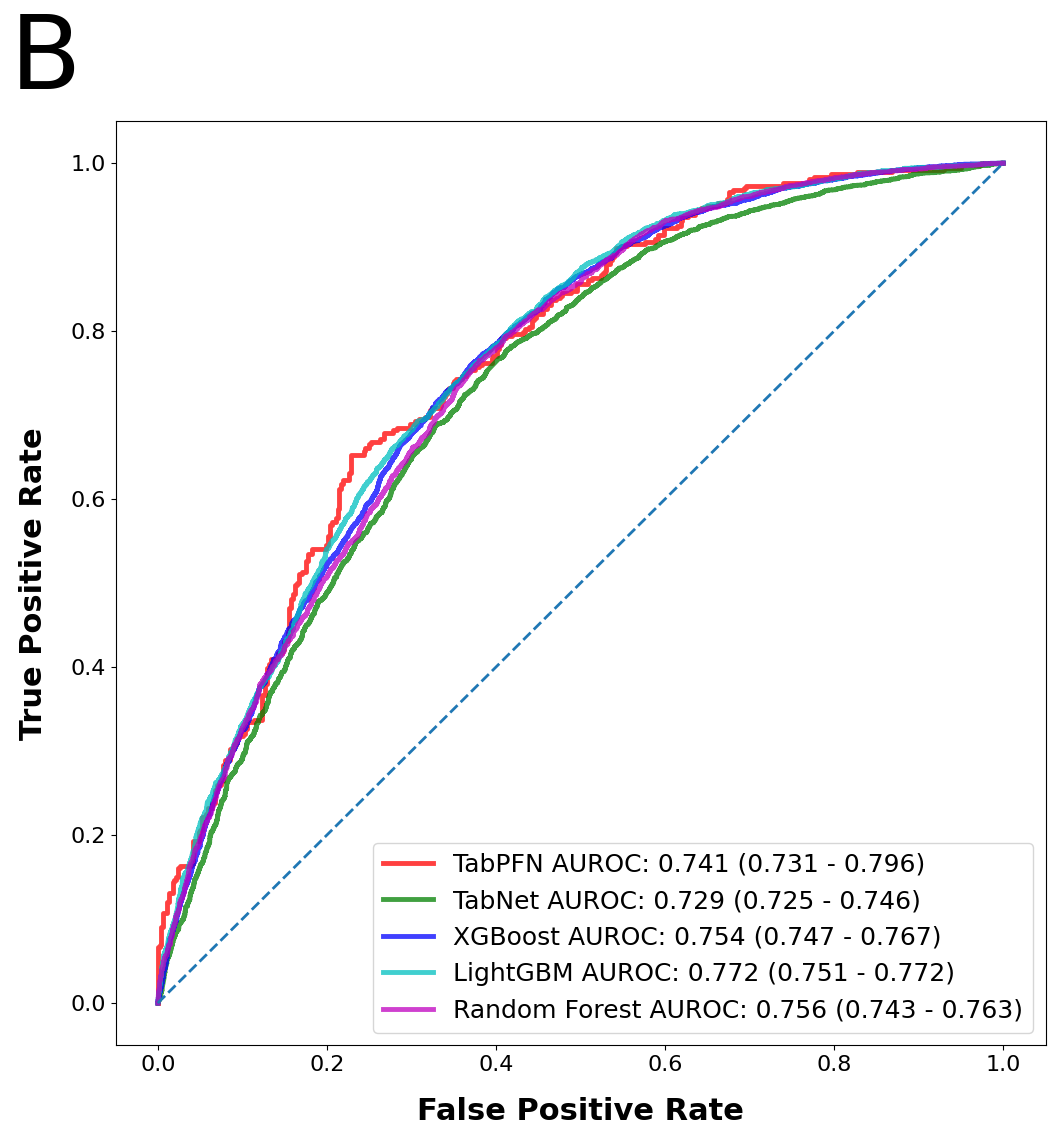

In [69]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_fpr, tabpfn_tpr, _ = roc_curve(tabpfn_y_test, probs_tabpfn)
tabpfn_label = 'TabPFN AUROC: ' + tabpfn_auroc_str
pyplot.plot(tabpfn_fpr, tabpfn_tpr, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)

tabnet_fpr, tabnet_tpr, _ = roc_curve(y_test, probs_tabnet)
tabnet_label = 'TabNet AUROC: ' + tabnet_auroc_str
pyplot.plot(tabnet_fpr, tabnet_tpr, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc_str
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc_str
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='c', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc_str
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('B', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_roc.png', dpi=300)
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


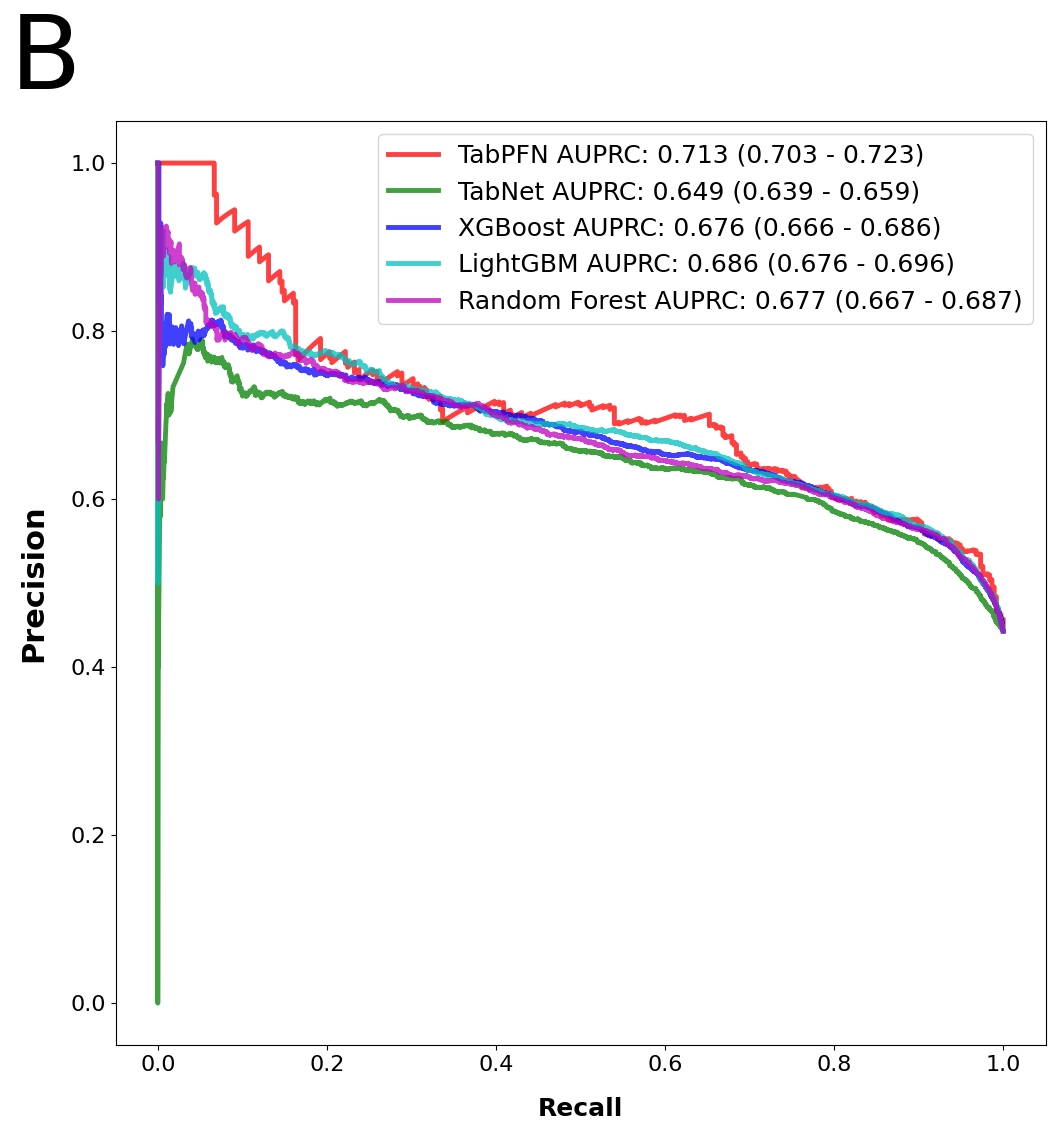

In [70]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_label = 'TabPFN AUPRC: ' + tabpfn_auprc_str
tabnet_label = 'TabNet AUPRC: ' + tabnet_auprc_str
xgb_label = 'XGBoost AUPRC: ' + xgb_auprc_str
lgb_label = 'LightGBM AUPRC: ' + lgb_auprc_str
rf_label = 'Random Forest AUPRC: ' + rf_auprc_str

pyplot.plot(tabpfn_recall_curve, tabpfn_precision_curve, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)
pyplot.plot(tabnet_recall_curve, tabnet_precision_curve, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)
pyplot.plot(xgb_recall_curve, xgb_precision_curve, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall_curve, lgb_precision_curve, label = lgb_label, color = 'c', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall_curve, rf_precision_curve, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.title('B', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 18, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [71]:
#Calculate means.

mean_precision = round((sum(list([tabpfn_precision, tabnet_precision, xgb_precision, lgb_precision, rf_precision]))/5), 3)
mean_precision_ci_lower = round((sum(list([tabpfn_precision_ci_lower, tabnet_precision_ci_lower, xgb_precision_ci_lower, lgb_precision_ci_lower, rf_precision_ci_lower]))/5), 3)
mean_precision_ci_upper = round((sum(list([tabpfn_precision_ci_upper, tabnet_precision_ci_upper, xgb_precision_ci_upper, lgb_precision_ci_upper, rf_precision_ci_upper]))/5), 3)
mean_precision_str = str(mean_precision) + ' (' + str(mean_precision_ci_lower) + ' - ' + str(mean_precision_ci_upper) + ')'

mean_recall = round((sum(list([tabpfn_recall, tabnet_recall, xgb_recall, lgb_recall, rf_recall]))/5), 3)
mean_recall_ci_lower = round((sum(list([tabpfn_recall_ci_lower, tabnet_recall_ci_lower, xgb_recall_ci_lower, lgb_recall_ci_lower, rf_recall_ci_lower]))/5), 3)
mean_recall_ci_upper = round((sum(list([tabpfn_recall_ci_upper, tabnet_recall_ci_upper, xgb_recall_ci_upper, lgb_recall_ci_upper, rf_recall_ci_upper]))/5), 3)
mean_recall_str = str(mean_recall) + ' (' + str(mean_recall_ci_lower) + ' - ' + str(mean_recall_ci_upper) + ')'

mean_auprc = round((sum(list([tabpfn_auprc, tabnet_auprc, xgb_auprc, lgb_auprc, rf_auprc]))/5), 3)
mean_auprc_ci_lower = round((sum(list([tabpfn_auprc_ci_lower, tabnet_auprc_ci_lower, xgb_auprc_ci_lower, lgb_auprc_ci_lower, rf_auprc_ci_lower]))/5), 3)
mean_auprc_ci_upper = round((sum(list([tabpfn_auprc_ci_upper, tabnet_auprc_ci_upper, xgb_auprc_ci_upper, lgb_auprc_ci_upper, rf_auprc_ci_upper]))/5), 3)
mean_auprc_str = str(mean_auprc) + ' (' + str(mean_auprc_ci_lower) + ' - ' + str(mean_auprc_ci_upper) + ')'

mean_accuracy = round((sum(list([tabpfn_accuracy, tabnet_accuracy, xgb_accuracy, lgb_accuracy, rf_accuracy]))/5), 3)
mean_accuracy_ci_lower = round((sum(list([tabpfn_accuracy_ci_lower, tabnet_accuracy_ci_lower, xgb_accuracy_ci_lower, lgb_accuracy_ci_lower, rf_accuracy_ci_lower]))/5), 3)
mean_accuracy_ci_upper = round((sum(list([tabpfn_accuracy_ci_upper, tabnet_accuracy_ci_upper, xgb_accuracy_ci_upper, lgb_accuracy_ci_upper, rf_accuracy_ci_upper]))/5), 3)
mean_accuracy_str = str(mean_accuracy) + ' (' + str(mean_accuracy_ci_lower) + ' - ' + str(mean_accuracy_ci_upper) + ')'

mean_auroc = round((sum(list([tabpfn_auroc, tabnet_auroc, xgb_auroc, lgb_auroc, rf_auroc]))/5), 3)
mean_auroc_ci_lower = round((sum(list([tabpfn_auroc_ci_lower, tabnet_auroc_ci_lower, xgb_auroc_ci_lower, lgb_auroc_ci_lower, rf_auroc_ci_lower]))/5), 3)
mean_auroc_ci_upper = round((sum(list([tabpfn_auroc_ci_upper, tabnet_auroc_ci_upper, xgb_auroc_ci_upper, lgb_auroc_ci_upper, rf_auroc_ci_upper]))/5), 3)
mean_auroc_str = str(mean_auroc) + ' (' + str(mean_auroc_ci_lower) + ' - ' + str(mean_auroc_ci_upper) + ')'

mean_brier = round((sum(list([tabpfn_brier, tabnet_brier, xgb_brier, lgb_brier, rf_brier]))/5), 3)
mean_brier_ci_lower = round((sum(list([tabpfn_brier_ci_lower, tabnet_brier_ci_lower, xgb_brier_ci_lower, lgb_brier_ci_lower, rf_brier_ci_lower]))/5), 3)
mean_brier_ci_upper = round((sum(list([tabpfn_brier_ci_upper, tabnet_brier_ci_upper, xgb_brier_ci_upper, lgb_brier_ci_upper, rf_brier_ci_upper]))/5), 3)
mean_brier_str = str(mean_brier) + ' (' + str(mean_brier_ci_lower) + ' - ' + str(mean_brier_ci_upper) + ')'

mean_results = [mean_precision_str, mean_recall_str, mean_auprc_str, mean_accuracy_str, mean_auroc_str, mean_brier_str]

In [72]:
results = {'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results}

results = pd.DataFrame(results, columns = ['TabPFN', 'TabNet', 'XGBoost', 'LightGBM', 'Random Forest', 'Mean'])

results

TabPFN                 TabNet                XGBoost  \
0  0.697 (0.687 - 0.707)      0.69 (0.68 - 0.7)      0.7 (0.69 - 0.71)   
1  0.686 (0.676 - 0.696)  0.673 (0.663 - 0.683)  0.686 (0.676 - 0.696)   
2  0.713 (0.703 - 0.723)  0.649 (0.639 - 0.659)  0.676 (0.666 - 0.686)   
3  0.691 (0.681 - 0.701)  0.682 (0.672 - 0.692)  0.694 (0.684 - 0.704)   
4  0.741 (0.731 - 0.796)  0.729 (0.725 - 0.746)  0.754 (0.747 - 0.767)   
5  0.197 (0.188 - 0.206)  0.206 (0.197 - 0.215)  0.198 (0.189 - 0.207)   

                LightGBM          Random Forest                   Mean  
0  0.701 (0.691 - 0.711)  0.698 (0.688 - 0.708)  0.697 (0.687 - 0.707)  
1  0.683 (0.673 - 0.693)  0.683 (0.673 - 0.693)  0.682 (0.672 - 0.692)  
2  0.686 (0.676 - 0.696)  0.677 (0.667 - 0.687)     0.68 (0.67 - 0.69)  
3  0.692 (0.682 - 0.702)  0.691 (0.681 - 0.701)      0.69 (0.68 - 0.7)  
4  0.772 (0.751 - 0.772)  0.756 (0.743 - 0.763)   0.75 (0.739 - 0.769)  
5  0.196 (0.187 - 0.205)   0.199 (0.19 - 0.208)   0.199 (0.19 - 0.208)

In [73]:
results = pd.DataFrame({'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results})

results = results.T

results.columns = ['Weighted Precision (95% CI)', 'Weighted Recall (95% CI)',  'Weighted AUPRC (95% CI)', 'Balanced Accuracy (95% CI)', 'AUROC (95% CI)', 'Brier Score']

results.to_csv('/content/drive/MyDrive/TQP-atSDH/discharge_results.csv')

results

Weighted Precision (95% CI) Weighted Recall (95% CI)  \
TabPFN              0.697 (0.687 - 0.707)    0.686 (0.676 - 0.696)   
TabNet                  0.69 (0.68 - 0.7)    0.673 (0.663 - 0.683)   
XGBoost                 0.7 (0.69 - 0.71)    0.686 (0.676 - 0.696)   
LightGBM            0.701 (0.691 - 0.711)    0.683 (0.673 - 0.693)   
Random Forest       0.698 (0.688 - 0.708)    0.683 (0.673 - 0.693)   
Mean                0.697 (0.687 - 0.707)    0.682 (0.672 - 0.692)   

              Weighted AUPRC (95% CI) Balanced Accuracy (95% CI)  \
TabPFN          0.713 (0.703 - 0.723)      0.691 (0.681 - 0.701)   
TabNet          0.649 (0.639 - 0.659)      0.682 (0.672 - 0.692)   
XGBoost         0.676 (0.666 - 0.686)      0.694 (0.684 - 0.704)   
LightGBM        0.686 (0.676 - 0.696)      0.692 (0.682 - 0.702)   
Random Forest   0.677 (0.667 - 0.687)      0.691 (0.681 - 0.701)   
Mean               0.68 (0.67 - 0.69)          0.69 (0.68 - 0.7)   

                      AUROC (95% CI)            Brier Score  
TabPFN         0.741 (0.731 - 0.796)  0.197 (0.188 - 0.206)  
TabNet         0.729 (0.725 - 0.746)  0.206 (0.197 - 0.215)  
XGBoost        0.754 (0.747 - 0.767)  0.198 (0.189 - 0.207)  
LightGBM       0.772 (0.751 - 0.772)  0.196 (0.187 - 0.205)  
Random Forest  0.756 (0.743 - 0.763)   0.199 (0.19 - 0.208)  
Mean            0.75 (0.739 - 0.769)   0.199 (0.19 - 0.208)

# SHAP Plots

In [74]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [75]:
x_test = x_test[x_test['Age'] > 18]
x_test = x_test[x_test['Age'] < 90]

x_test = x_test[x_test['Weight'] > 30]
x_test = x_test[x_test['Weight'] < 250]

x_test = x_test[x_test['Systolic Blood Pressure'] > 50]
x_test = x_test[x_test['Systolic Blood Pressure'] < 250]

x_test = x_test[x_test['Pulse Rate'] > 20]
x_test = x_test[x_test['Pulse Rate'] < 220]

x_test = x_test[x_test['Respiratory Rate'] > 4]
x_test = x_test[x_test['Respiratory Rate'] < 50]

In [76]:
x_test_sample = x_test.sample(frac=0.05, random_state=42)
tabpfn_x_test_sample = tabpfn_x_test.sample(frac=0.05, random_state=42)
tabnet_x_test_sample = x_test.sample(frac=0.05, random_state = 31)

feature_names = x_test_sample.columns

In [77]:
#Calculate SHAP values for TabPFN.

tabpfn_explainer = shap.Explainer(tabpfn.predict, tabpfn_x_test_sample)
tabpfn_shap_values = tabpfn_explainer(tabpfn_x_test_sample)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


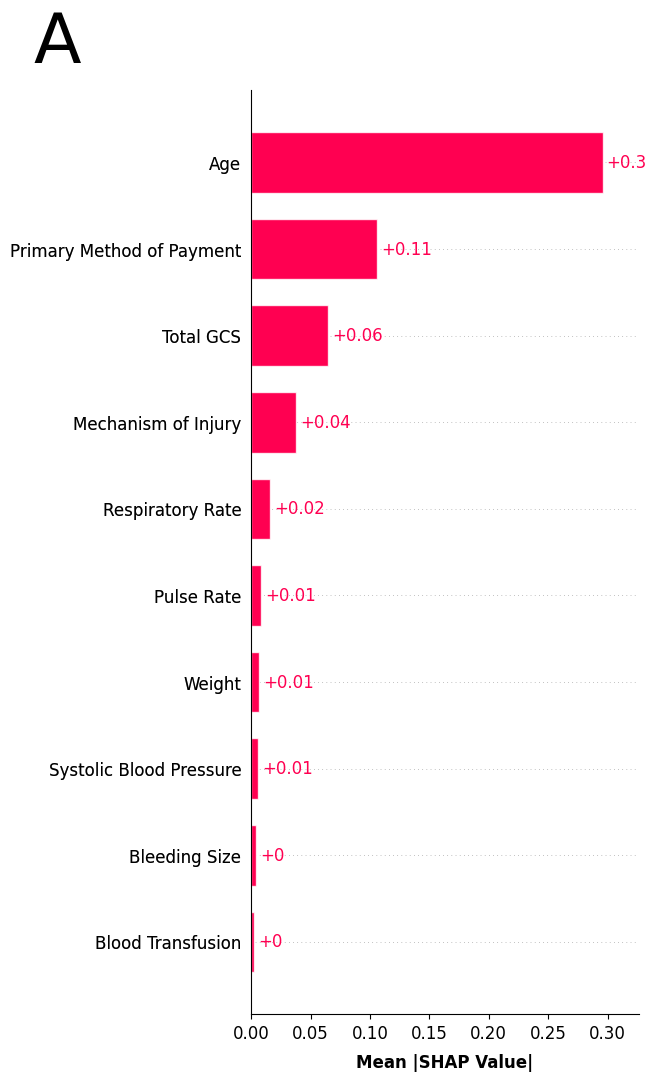

In [78]:
#Plot SHAP bar plot for TabPFN.

shap.plots.bar(tabpfn_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_shap_tabpfn.png', dpi=300, bbox_inches='tight')

In [79]:
#Calculate SHAP values for TabNet.

tabnet_explainer = shap.Explainer(tabnet.predict, x_test_sample.values, feature_names=feature_names)
tabnet_shap_values = tabnet_explainer(x_test_sample.values)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


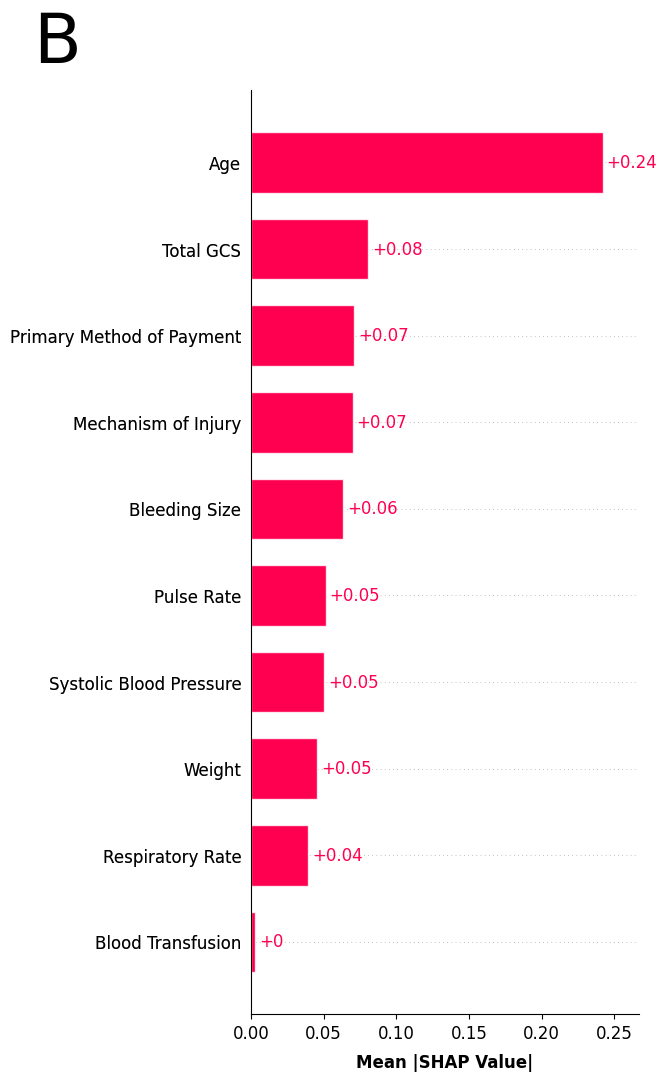

In [80]:
#Plot SHAP bar plot for TabNet.

shap.plots.bar(tabnet_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_shap_tabnet.png', dpi=300, bbox_inches='tight')

In [81]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test_sample)
xgb_shap_values = xgb_explainer(x_test_sample)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


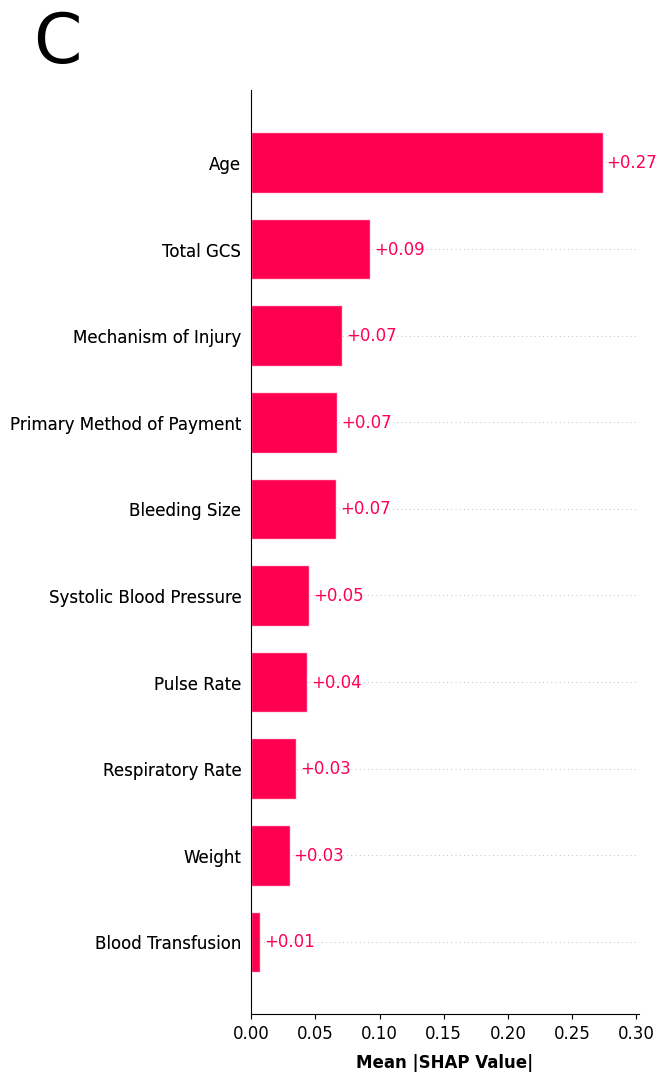

In [82]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_shap_xgb.png', dpi=300, bbox_inches='tight')

In [83]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test_sample)
lgb_shap_values = lgb_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


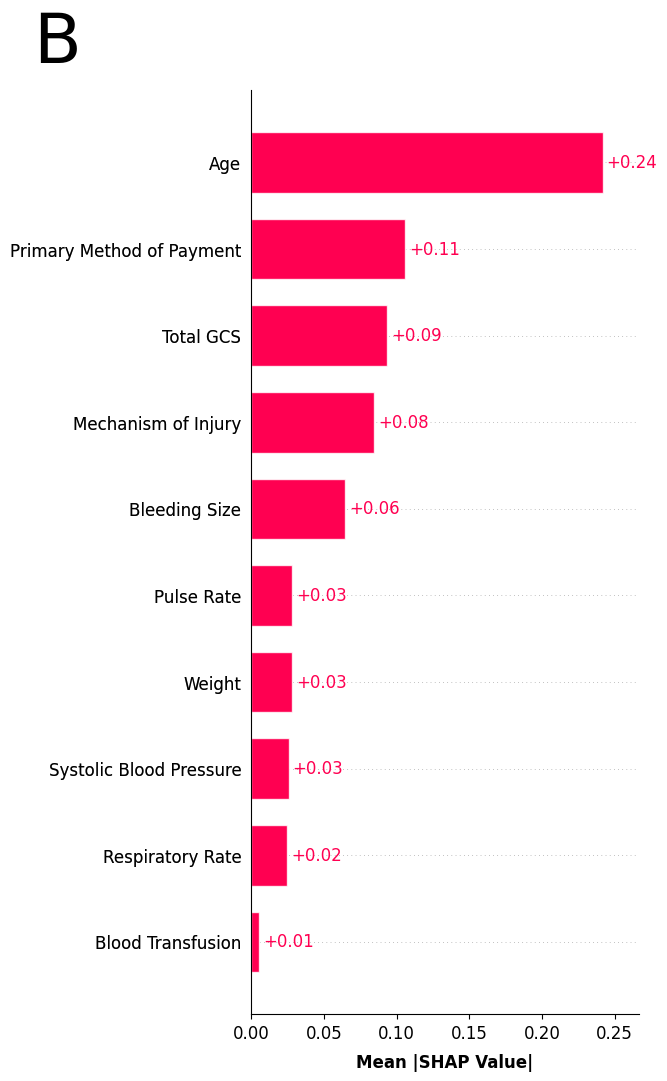

In [84]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_shap_lgb.png', dpi=300, bbox_inches='tight')

In [85]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test_sample)
rf_shap_values = rf_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


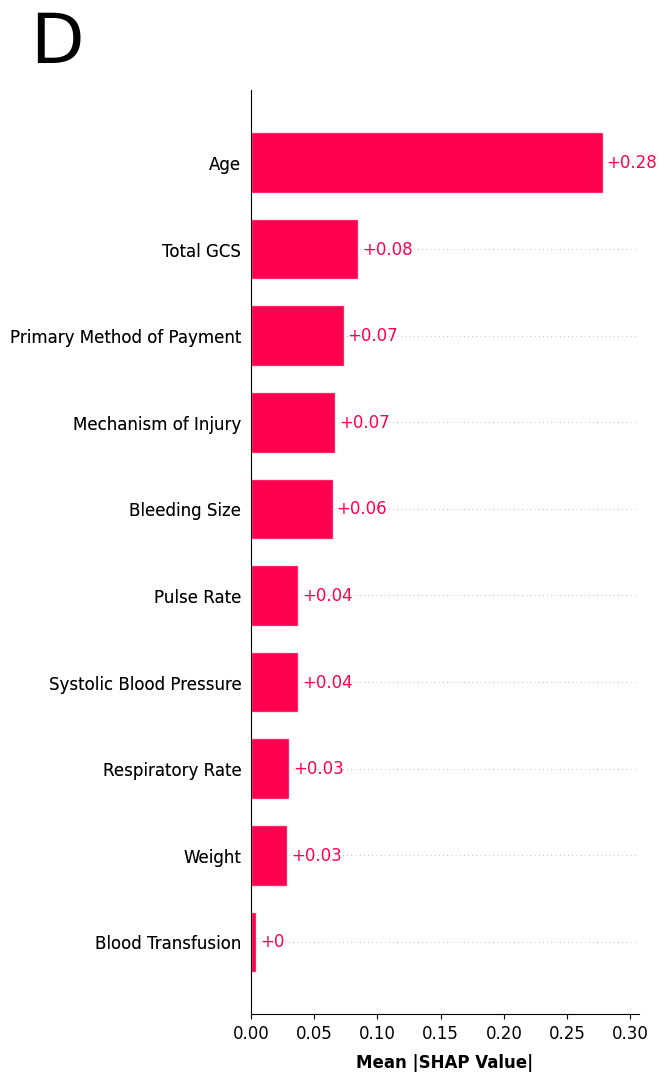

In [86]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_shap_rf.png', dpi=300, bbox_inches='tight')

#Partial Dependency Plots

In [87]:
pyplot.rcParams["figure.figsize"] = (15, 20)
pyplot.rcParams["figure.dpi"] = 300
pyplot.rcParams['axes.labelweight'] = 'bold'
pyplot.rcParams['axes.labelsize'] = 12
pyplot.rcParams['axes.labelpad'] = 6
pyplot.rcParams['font.weight'] = 'normal'
pyplot.rcParams['lines.linewidth'] = 2.5
pyplot.rcParams['xtick.labelsize'] = 8
pyplot.rcParams['ytick.labelsize'] = 8

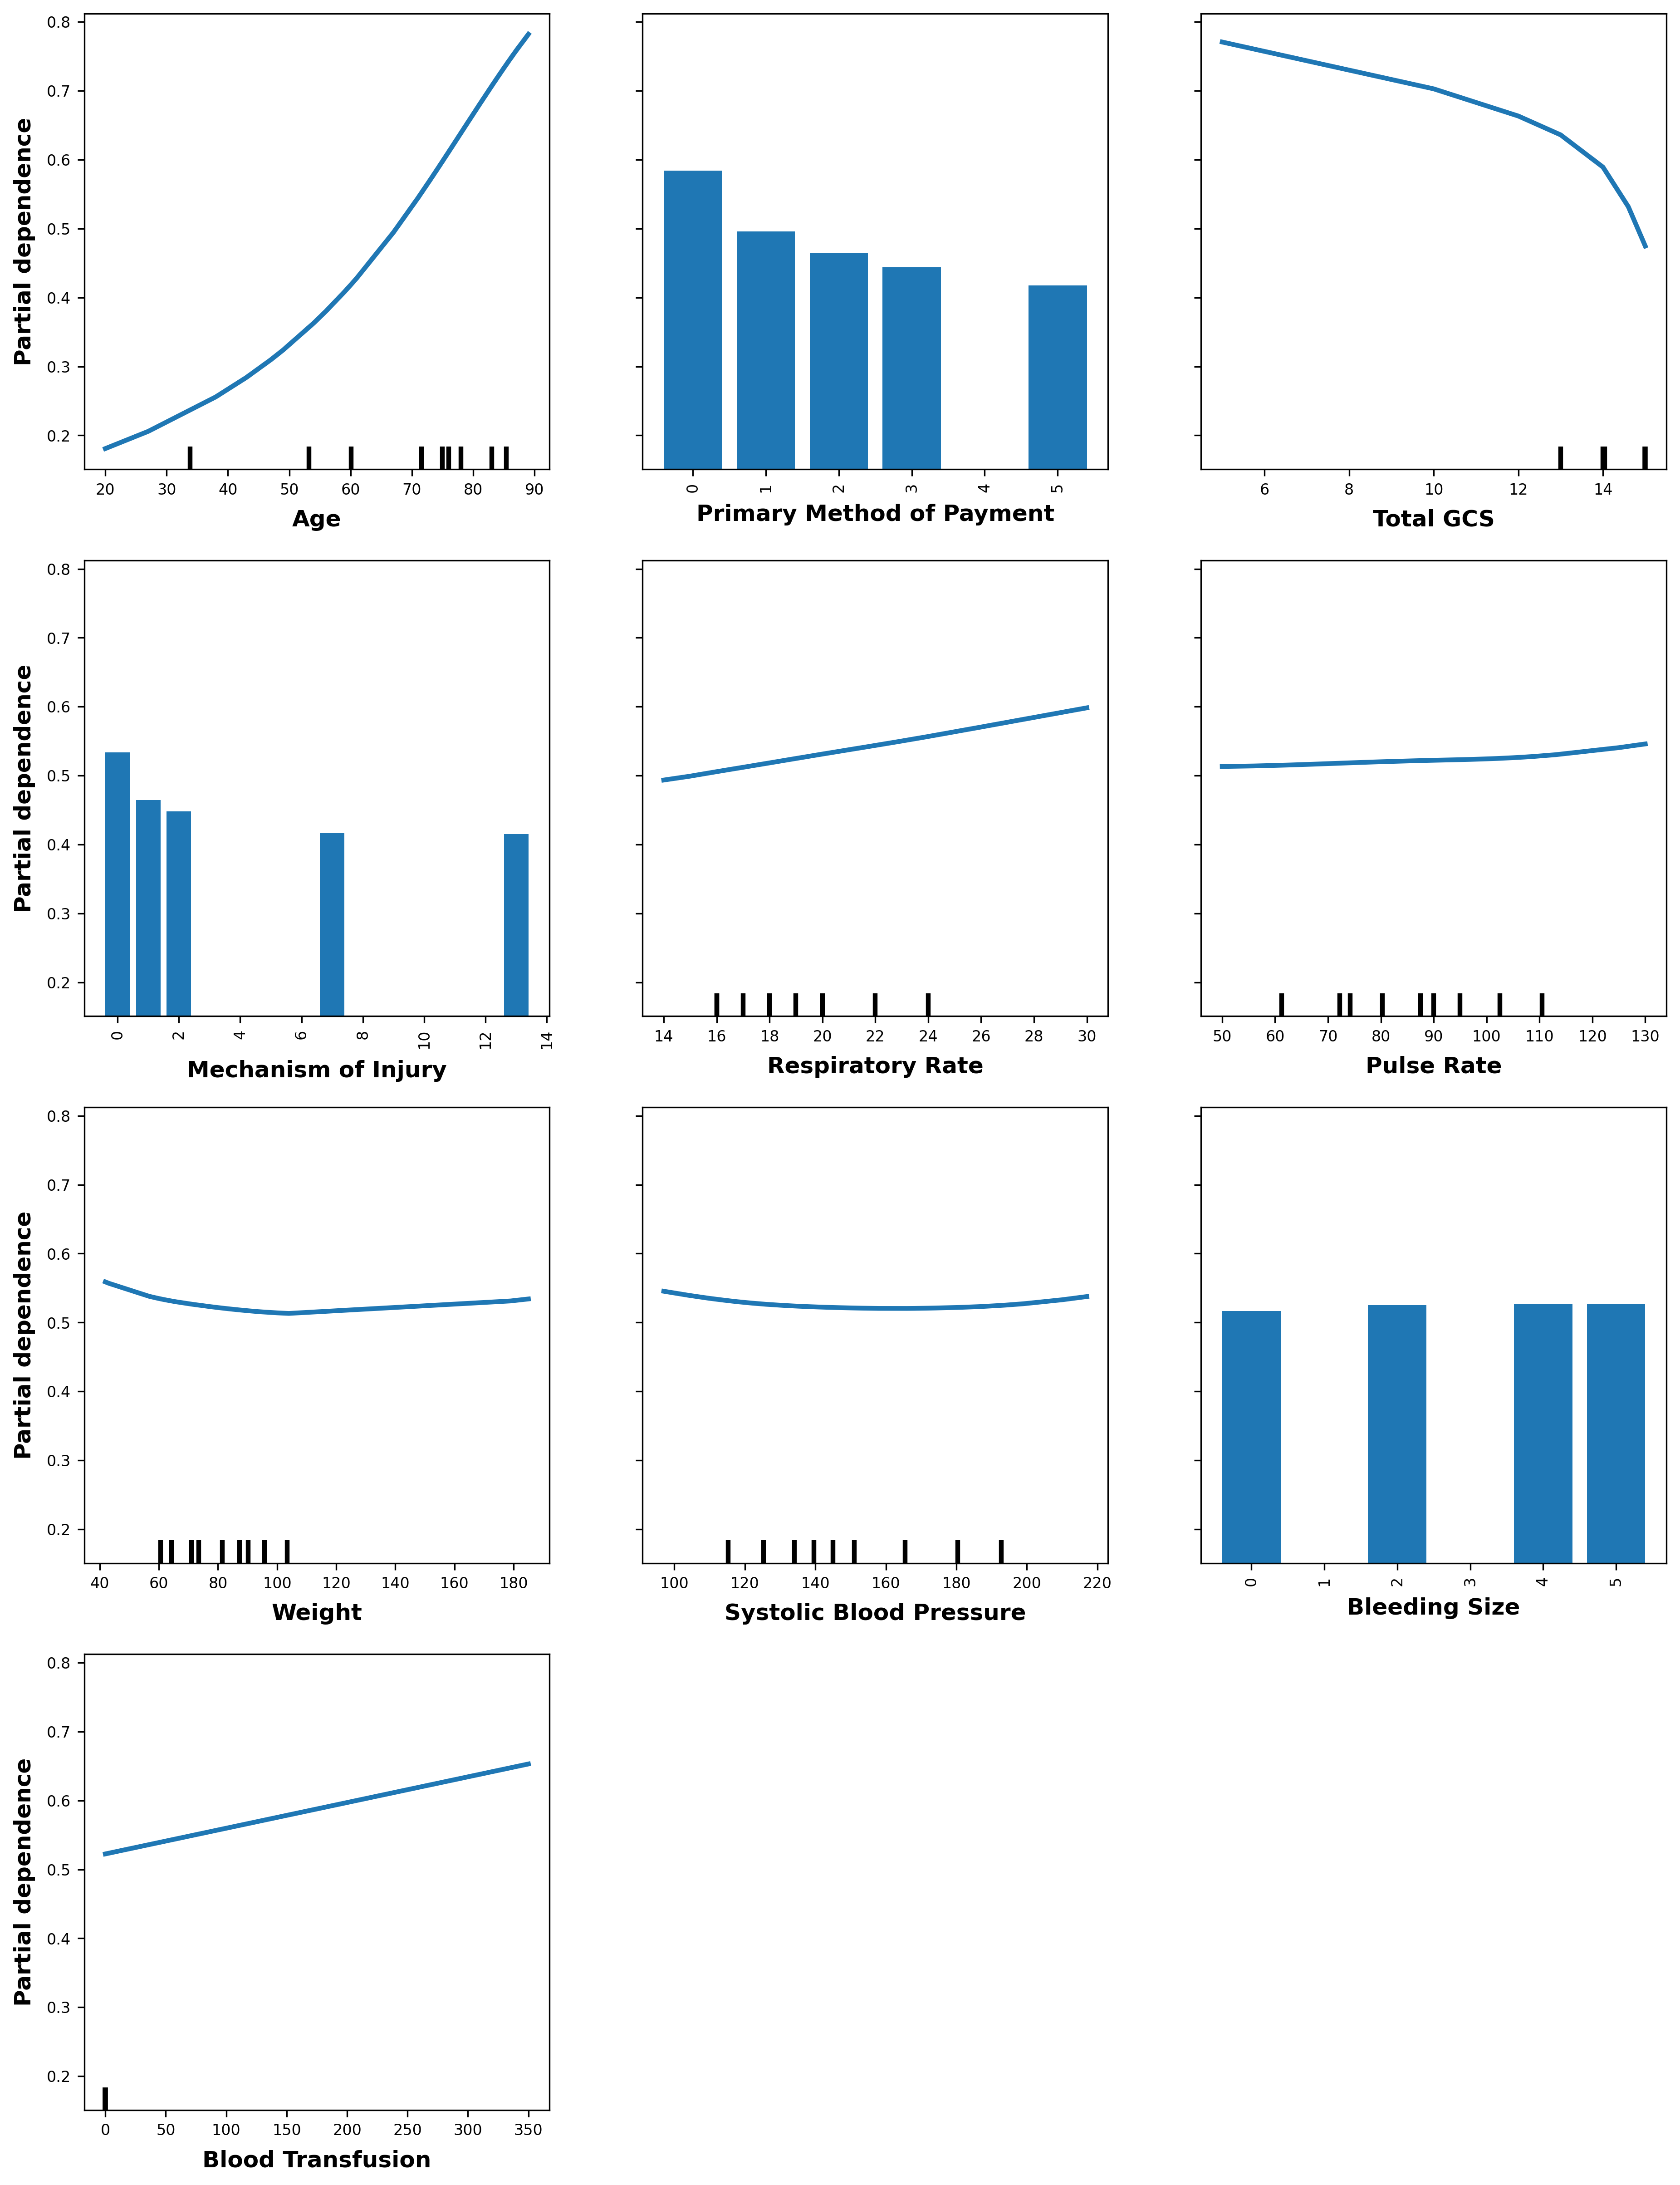

In [88]:
#Calculate the mean absolute SHAP values for each feature.
tabpfn_mean_abs_shap_values = np.mean(np.abs(tabpfn_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabpfn_shap_summary = pd.DataFrame(list(zip(feature_names, tabpfn_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabpfn_shap_summary_sorted = tabpfn_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabpfn_features = tabpfn_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(tabpfn, tabpfn_x_test_sample, tabpfn_features, categorical_features = ['Bleeding Size', 'Mechanism of Injury', 'Primary Method of Payment'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_pdp_tabpfn.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


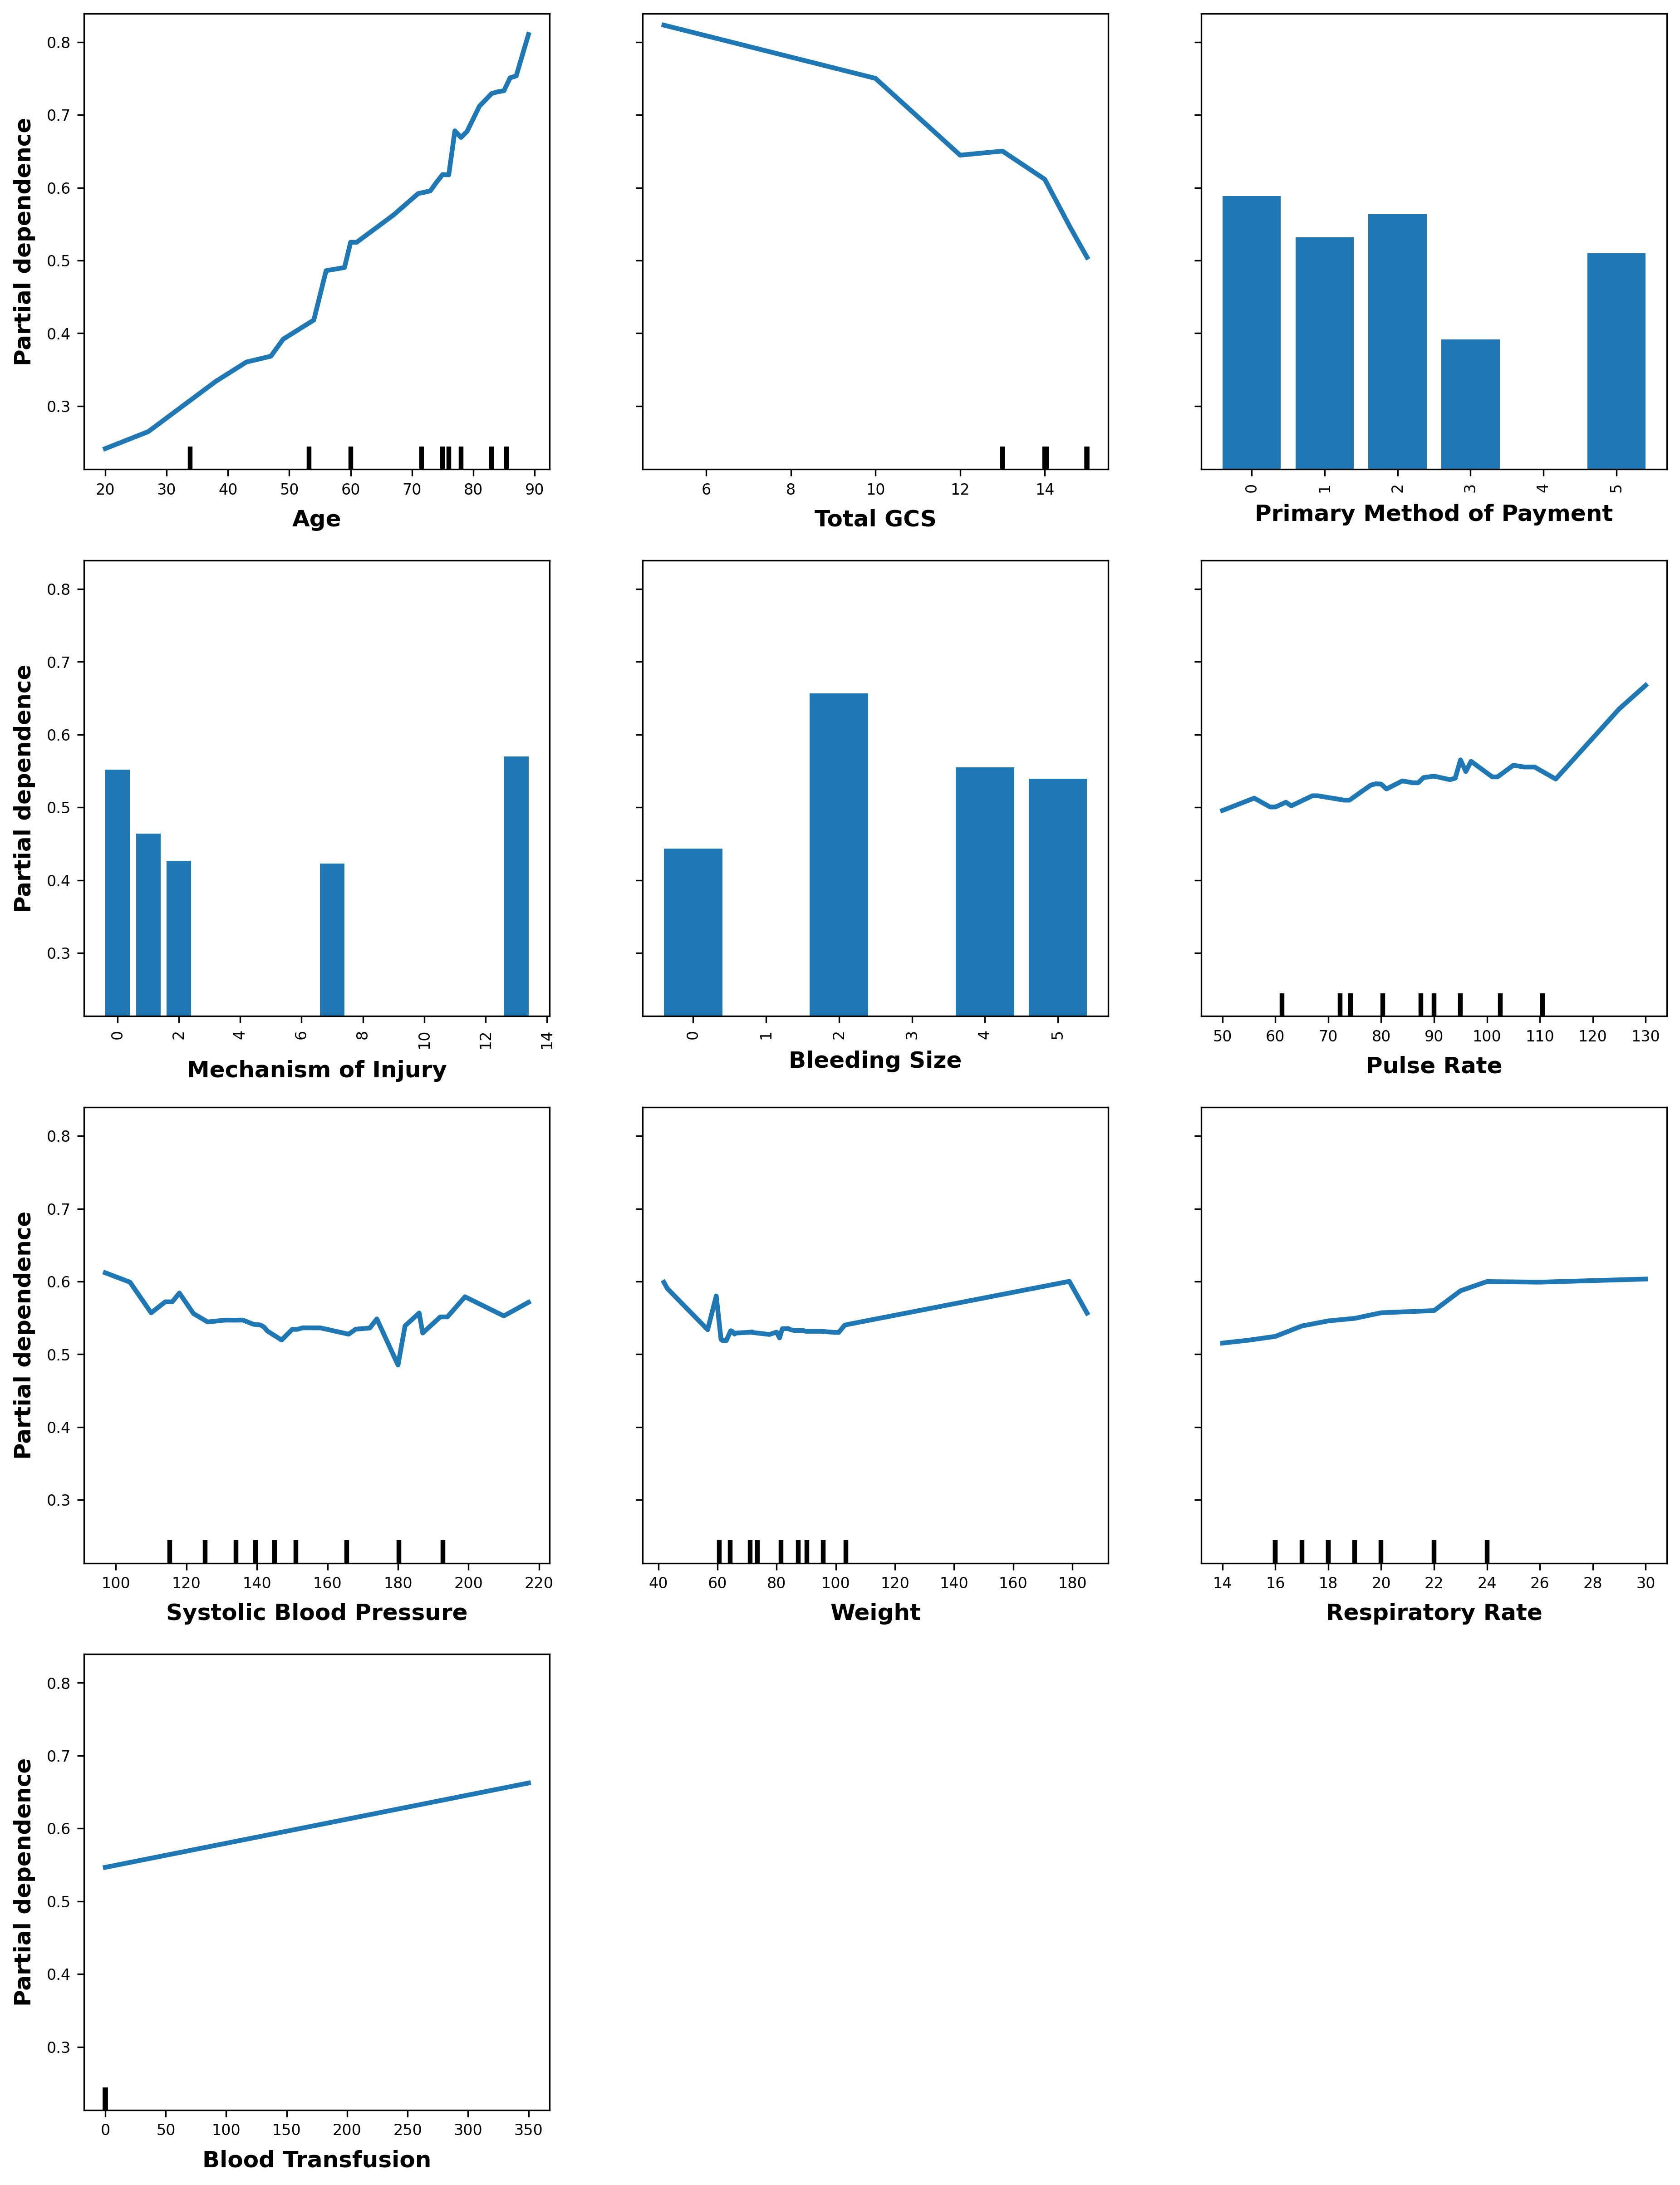

In [89]:
#Calculate the mean absolute SHAP values for each feature.
tabnet_mean_abs_shap_values = np.mean(np.abs(tabnet_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabnet_shap_summary = pd.DataFrame(list(zip(feature_names, tabnet_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabnet_shap_summary_sorted = tabnet_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabnet_features = tabnet_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, tabpfn_x_test_sample, tabnet_features, categorical_features = ['Bleeding Size', 'Mechanism of Injury', 'Primary Method of Payment'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_pdp_tabnet.png', dpi=300, bbox_inches='tight')
pyplot.show()

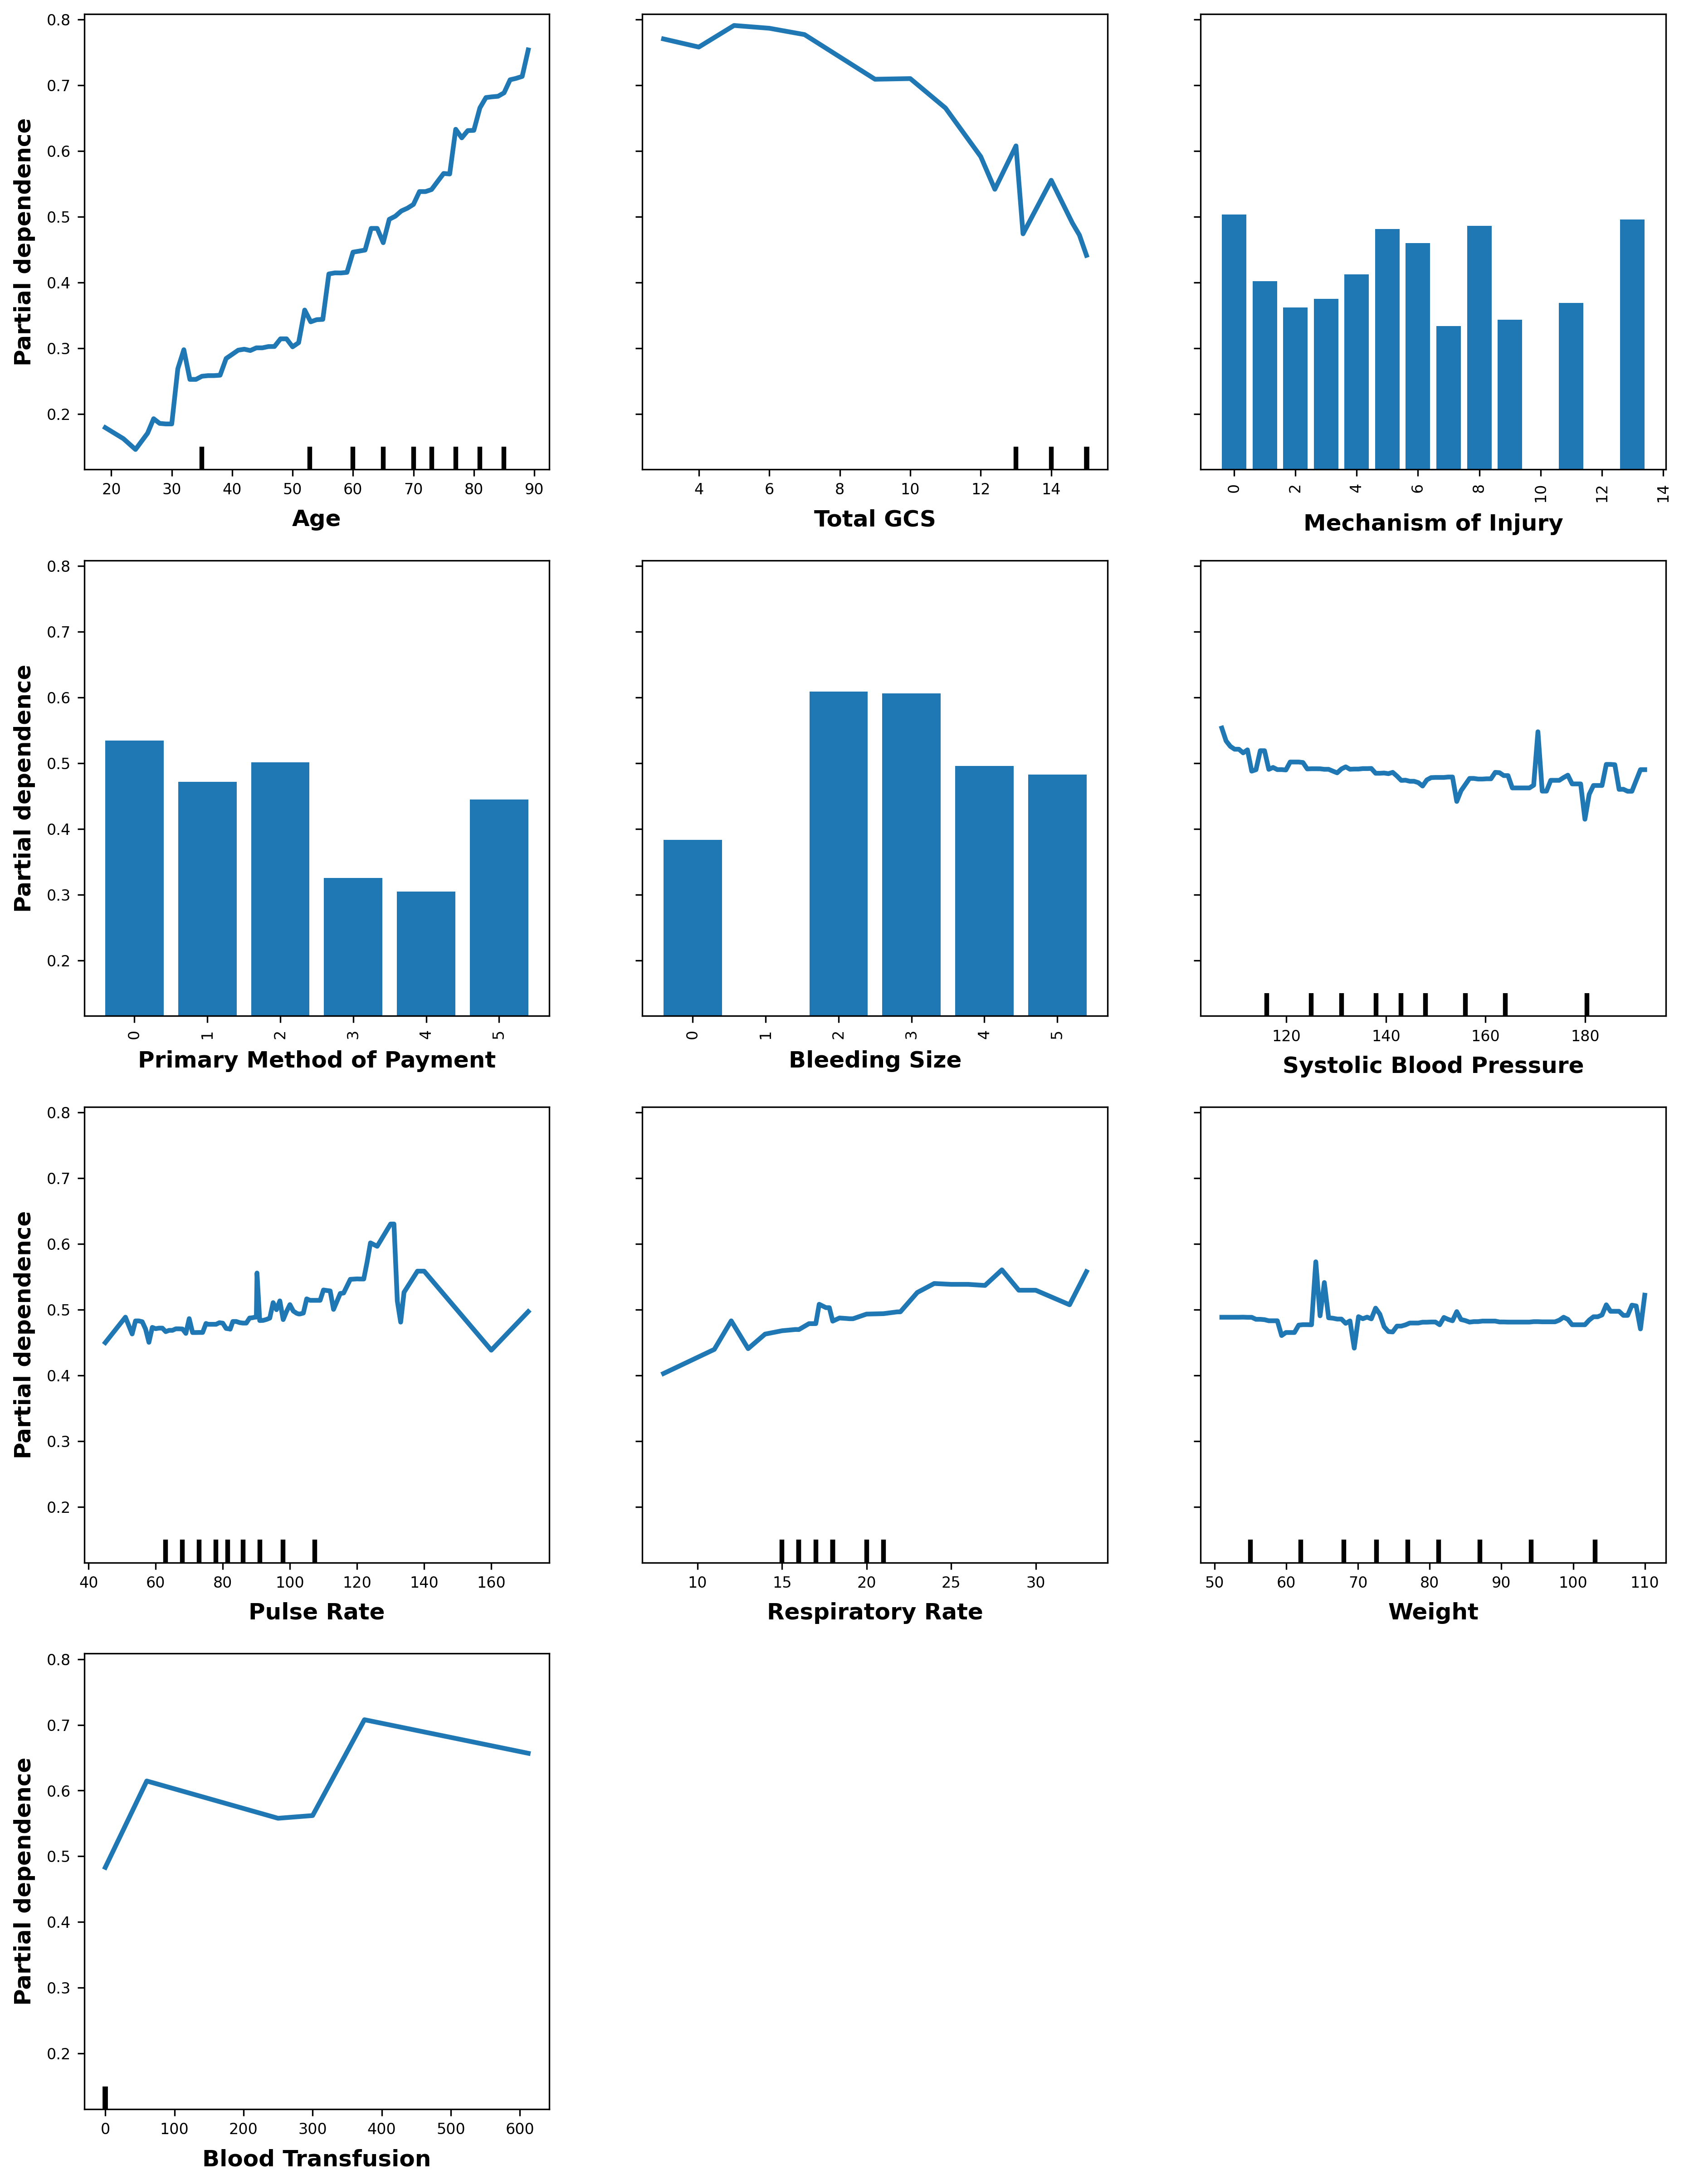

In [90]:
#Calculate the mean absolute SHAP values for each feature.
xgb_mean_abs_shap_values = np.mean(np.abs(xgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
xgb_shap_summary = pd.DataFrame(list(zip(feature_names, xgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
xgb_shap_summary_sorted = xgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
xgb_features = xgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, x_test_sample, xgb_features, categorical_features = ['Bleeding Size', 'Mechanism of Injury', 'Primary Method of Payment'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_pdp_xgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


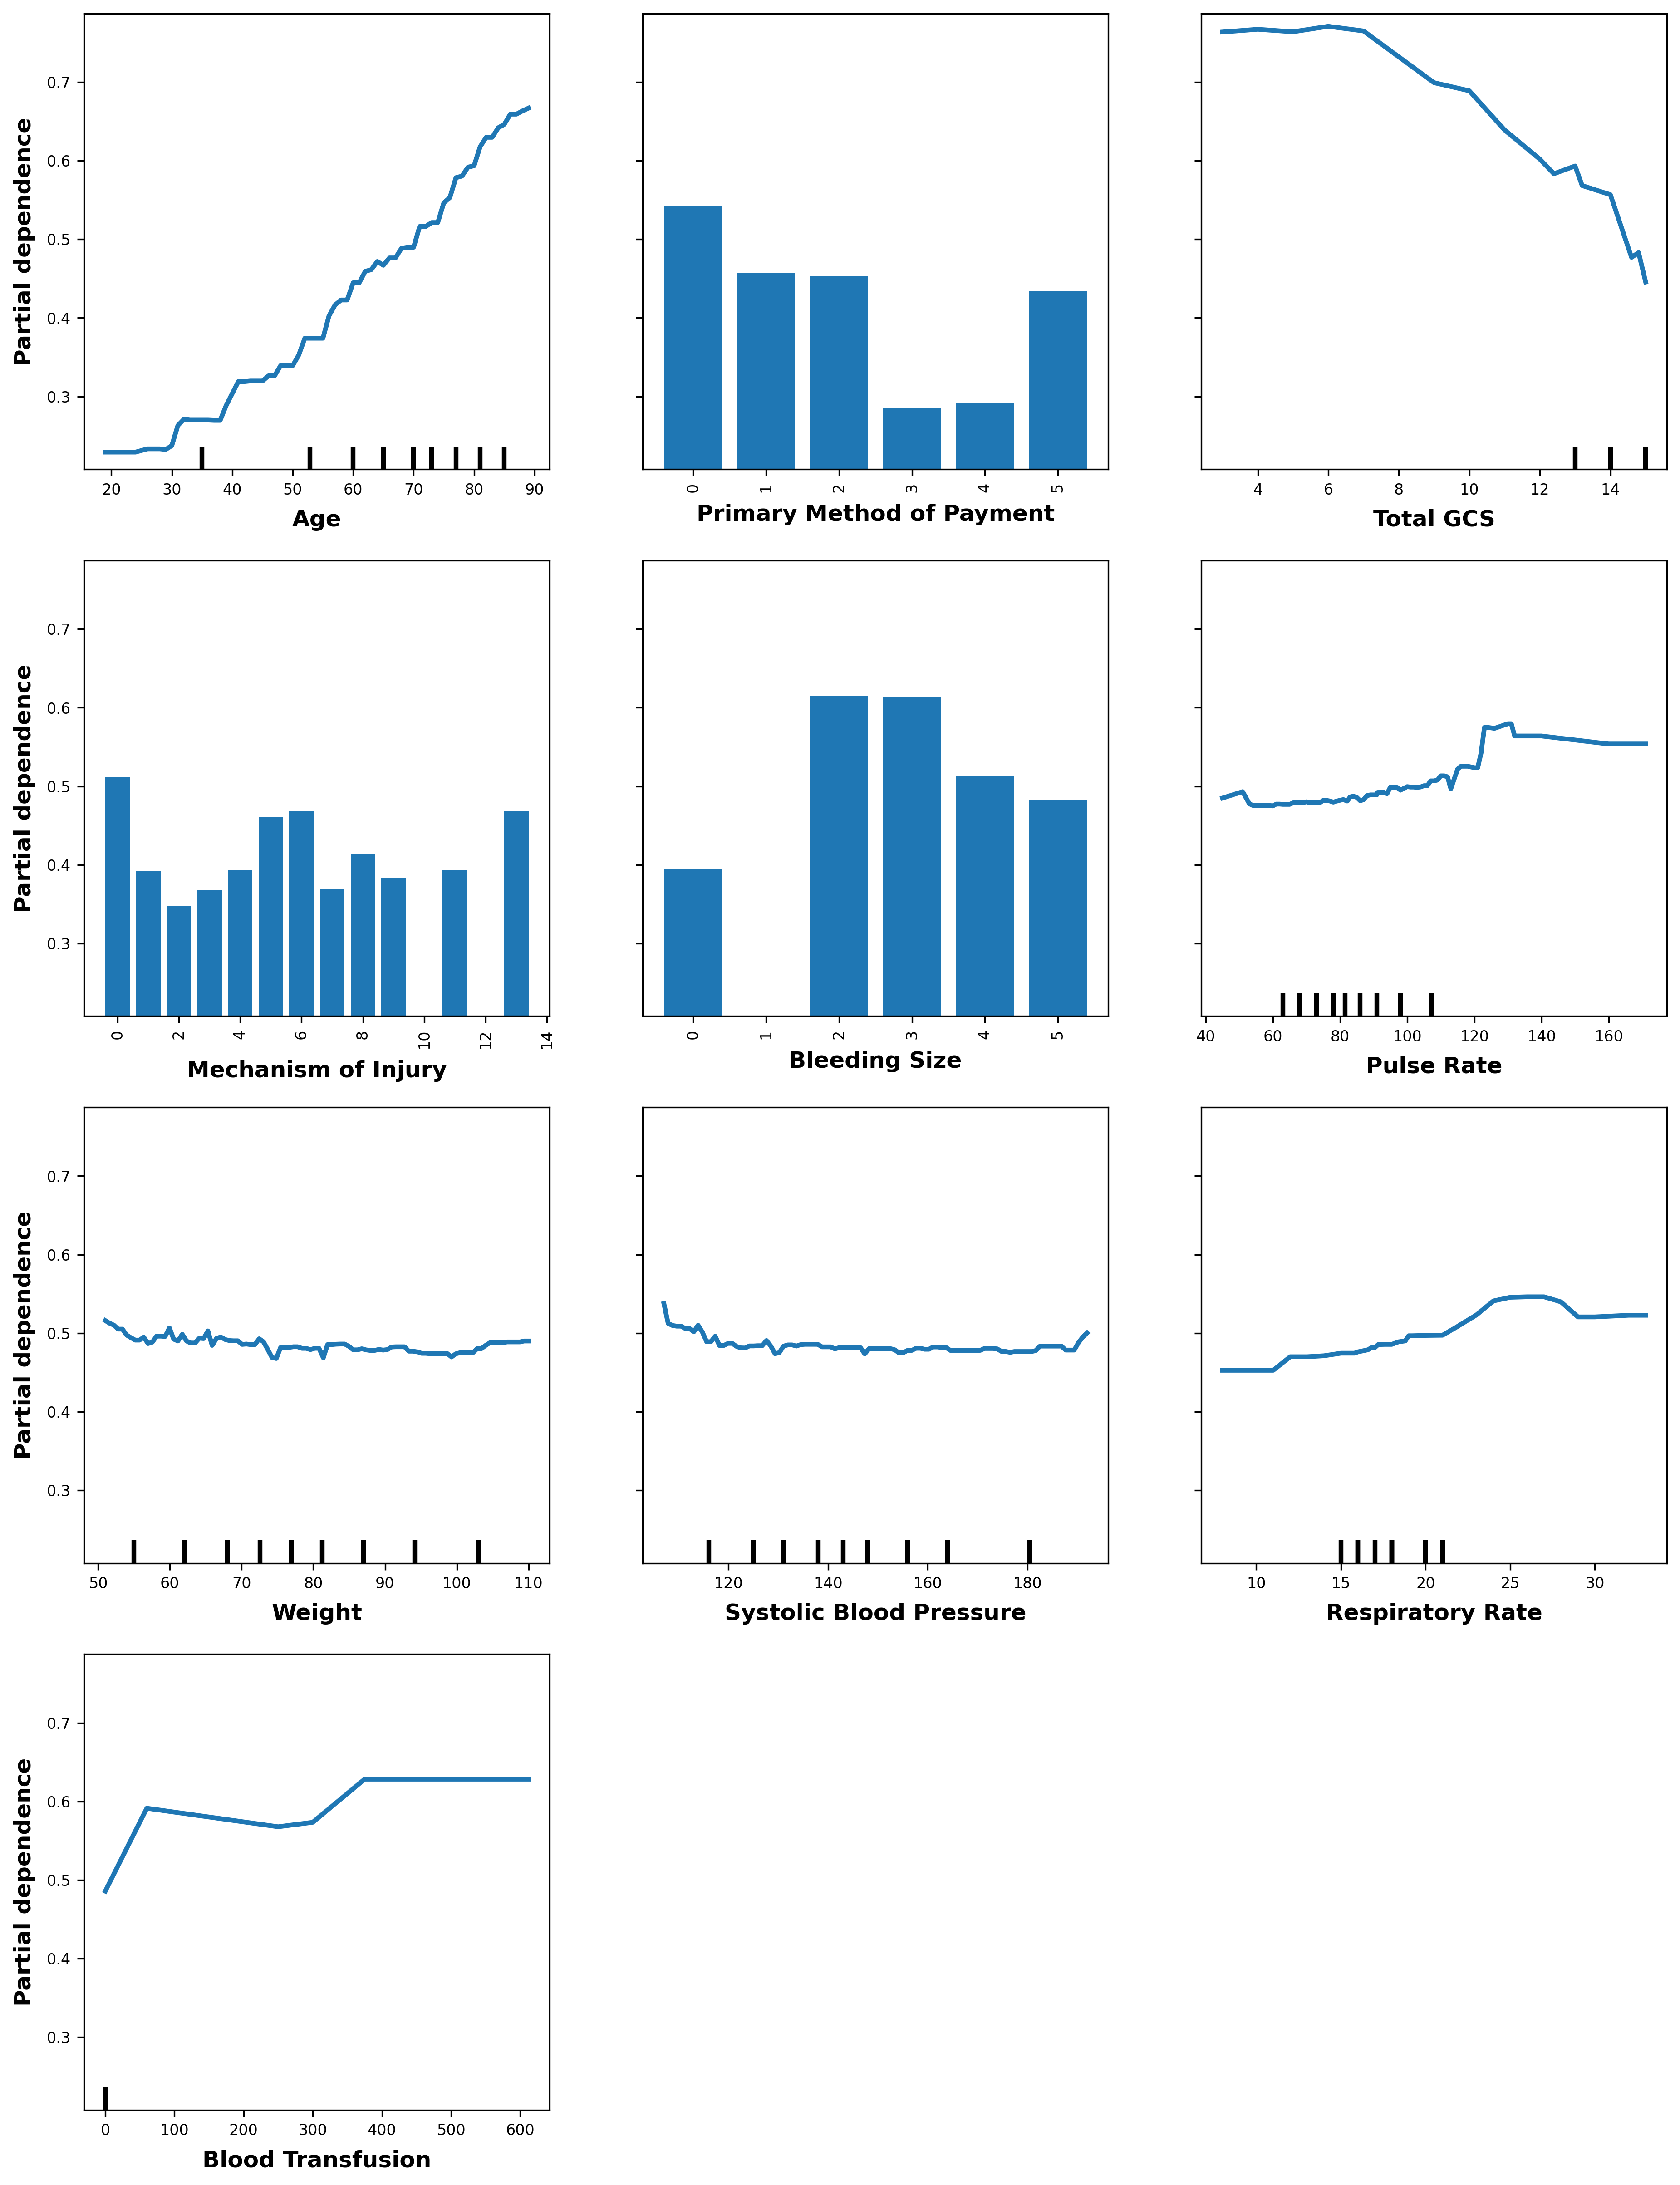

In [91]:
#Calculate the mean absolute SHAP values for each feature.
lgb_mean_abs_shap_values = np.mean(np.abs(lgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
lgb_shap_summary = pd.DataFrame(list(zip(feature_names, lgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
lgb_shap_summary_sorted = lgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
lgb_features = lgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(lgb, x_test_sample, lgb_features, categorical_features = ['Bleeding Size', 'Mechanism of Injury', 'Primary Method of Payment'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_pdp_lgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


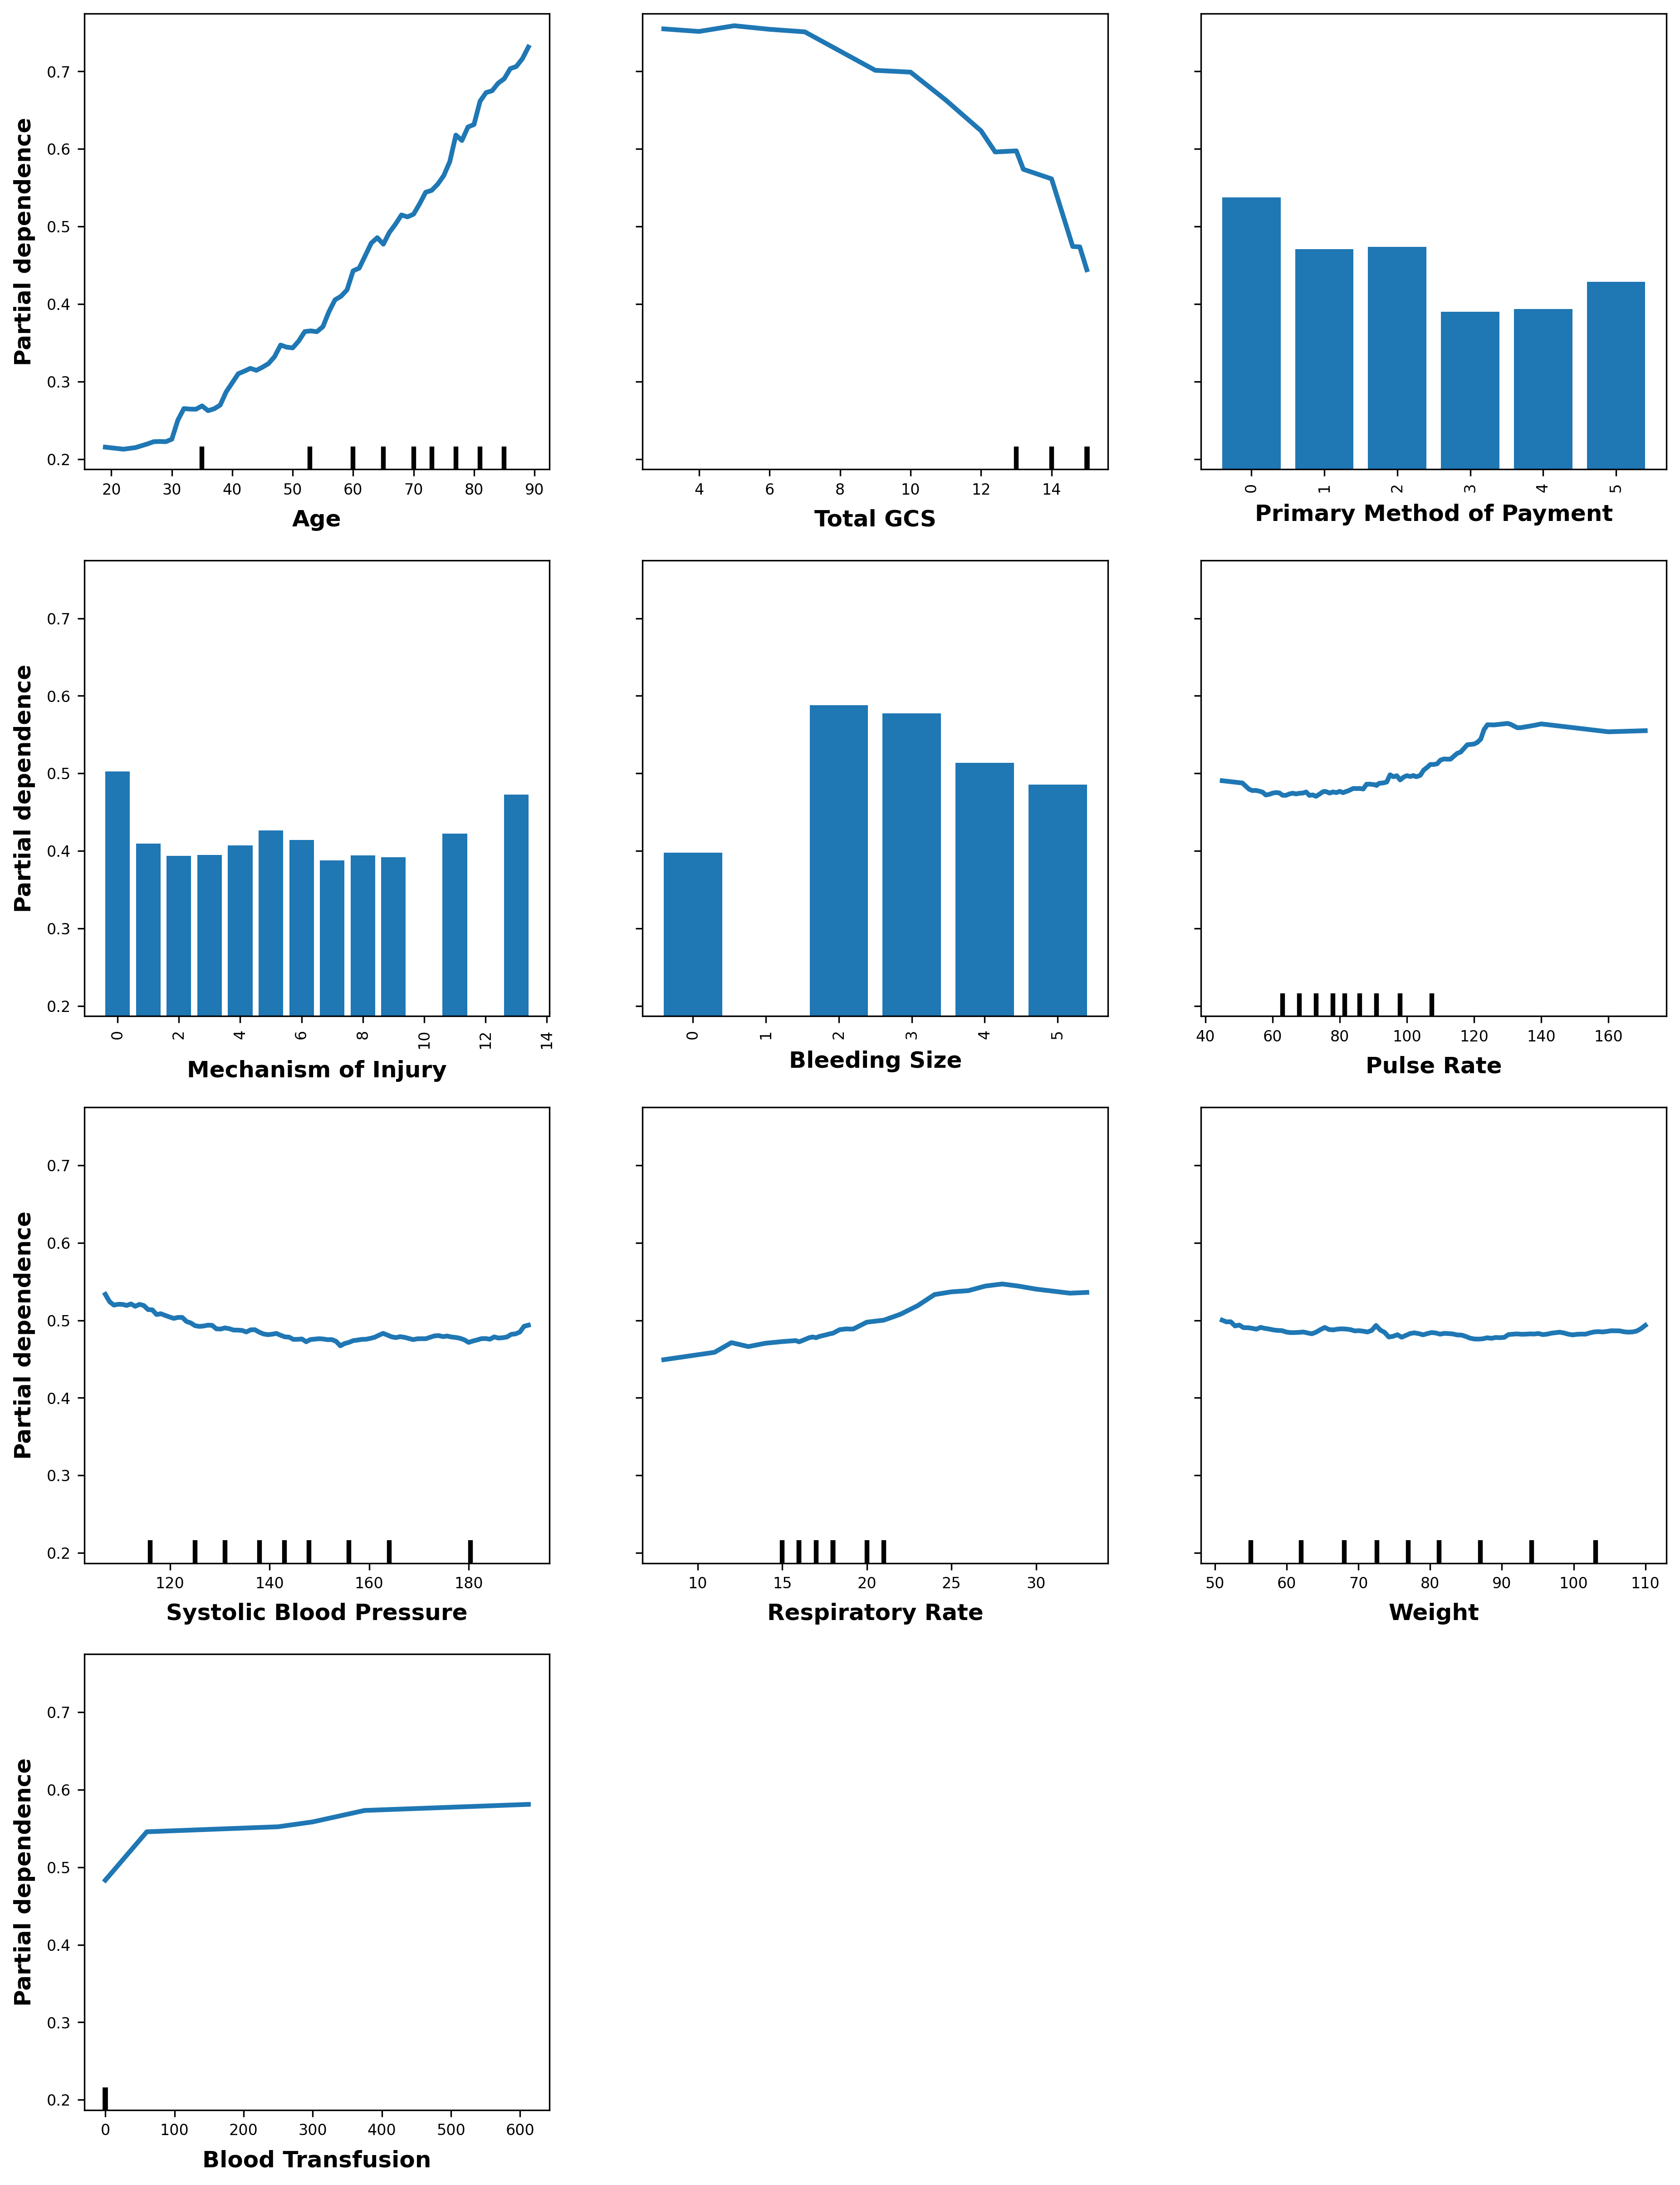

In [92]:
#Calculate the mean absolute SHAP values for each feature.
rf_mean_abs_shap_values = np.mean(np.abs(rf_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
rf_shap_summary = pd.DataFrame(list(zip(feature_names, rf_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
rf_shap_summary_sorted = rf_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
rf_features = rf_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(rf, x_test_sample, rf_features, categorical_features = ['Bleeding Size', 'Mechanism of Injury', 'Primary Method of Payment'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/discharge_pdp_rf.png', dpi=300, bbox_inches='tight')
pyplot.show()